# GSM8K pre-train vs RL evaluation visualization

Use this notebook to collect GSM8K evaluation scores from pre-training and RL runs under `/n/netscratch/dam_lab/Everyone/rl_pretrain/eval_results` and `/n/netscratch/dam_lab/Everyone/rl_pretrain/eval_results_sunny`, then plot how RL fine-tuning moves performance from its starting checkpoint.

In [5]:
from pathlib import Path
import re
import ast
import pandas as pd
import matplotlib.pyplot as plt

# Root locations for evaluation outputs and the metric key to read
BASE_DIRS = [
    Path("/n/netscratch/dam_lab/Everyone/rl_pretrain/eval_results"),
    Path("/n/netscratch/dam_lab/Everyone/rl_pretrain/eval_results_sunny"),
]
DATASET_KEY = "test_score/openai/gsm8k"

print(f"Base directories: {BASE_DIRS}")

Base directories: [PosixPath('/n/netscratch/dam_lab/Everyone/rl_pretrain/eval_results'), PosixPath('/n/netscratch/dam_lab/Everyone/rl_pretrain/eval_results_sunny')]


In [6]:
def read_score(result_path: Path, samples: int, dataset_key: str = DATASET_KEY):
    """Read score from either dict-style logs or majority-vote text.

    Returns:
        dict[int, float]: Dictionary mapping k values to scores.
                         For majority files, returns all Pass@k values found.
                         For dict-style files, returns {samples: score}.
                         Returns {} if no scores found.
    """
    if not result_path.exists():
        return {}

    text = result_path.read_text().splitlines()

    # Majority-format text file (pass@k, single-sample accuracy, etc.)
    if samples > 1 or "majority" in result_path.name:
        scores = {}
        for line in text:
            if "Pass@" in line and ":" in line:
                # Expect formats like: "  Pass@1 : 0.0403 (4.03%)" or "Pass@32 (Any Correct):  0.6884 (68.84%)"
                # Extract k value and score
                import re as _re
                # Match "Pass@<k>" pattern
                k_match = _re.search(r"Pass@(\d+)", line)
                if k_match:
                    k = int(k_match.group(1))
                    # Extract score after the colon
                    parts = line.split(":")
                    if len(parts) > 1:
                        try:
                            score = float(parts[1].split()[0])
                            scores[k] = score
                        except Exception:
                            pass
        if scores:
            return scores
        # If we didn't find Pass@, fall back to the dict parsing below

    # Dict-style log: scan from the bottom for a dict containing the key
    for line in reversed(text):
        try:
            payload = ast.literal_eval(line.strip())
        except Exception:
            continue
        if isinstance(payload, dict) and dataset_key in payload:
            return {samples: payload[dataset_key]}
    return {}

# Collect pre-train runs (pattern: 1B-step{step}-{shot}shot-{samples}samples-temp{temp})
pretrain_rows = []
pre_pattern = re.compile(r"1B-step(?P<step>\d+)-(?P<shot>\d+)shot-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$")

# Collect RL runs from both naming schemes below
#   1) olmo2_1b_step{pt_step}_omigsm8k_n{num_rollouts}-step{rl_step}-rl-...
#   2) olmo2_1b_step{pt_step}_omigsm8k_n{num_rollouts}_v{seed}-step{rl_step}-rl-...
rl_rows = []
rl_patterns = [
    # Pattern 1: without seed (default seed=1)
    re.compile(r"olmo2_1b_step(?P<pt_step>\d+)_omigsm8k_n(?P<num_rollouts>\d+)-step(?P<rl_step>\d+)-rl-0shot-boxed-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$"),
    # Pattern 2: with seed
    re.compile(r"olmo2_1b_step(?P<pt_step>\d+)_omigsm8k_n(?P<num_rollouts>\d+)_v(?P<seed>\d+)-step(?P<rl_step>\d+)-rl-0shot-boxed-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$"),
]

# Collect SFT runs
#   1) 1B-step{pt_step}-sft-step{sft_step}-0shot-boxed-{samples}samples-temp{temp}
#   2) OLMo2-1B-step{pt_step}-stage2-openmathgsm8k-step{sft_step}-hf-{shot}shot-{samples}samples-temp{temp}
sft_rows = []
sft_patterns = [
    re.compile(r"OLMo2-1B-step(?P<pt_step>\d+)-stage2-openmathgsm8k-step(?P<sft_step>\d+)-hf-(?P<shot>\d+)shot-boxed-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$", re.IGNORECASE),
    re.compile(r"OLMo2-1B-step(?P<pt_step>\d+)-stage2-openmathgsm8k-5epoch-step(?P<sft_step>\d+)-hf-(?P<shot>\d+)shot-boxed-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$", re.IGNORECASE),
    re.compile(r"OLMo2-1B-step(?P<pt_step>\d+)-stage2-openmathgsm8k-10epoch-step(?P<sft_step>\d+)-hf-(?P<shot>\d+)shot-boxed-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$", re.IGNORECASE),
]

# Collect SFTed-RL runs (RL on top of SFT models)
#   Pattern: olmo2_1b_step{pt_step}sfted_omigsm8k_n{num_rollouts}-step{rl_step}-rl-0shot-boxed-{samples}samples-temp{temp}
sfted_rl_rows = []
sfted_rl_pattern = re.compile(r"olmo2_1b_step(?P<pt_step>\d+)sfted_omigsm8k_n(?P<num_rollouts>\d+)-step(?P<rl_step>\d+)-rl-0shot-boxed-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$")

# Iterate over all base directories
for BASE_DIR in BASE_DIRS:
    if not BASE_DIR.exists():
        print(f"Warning: {BASE_DIR} does not exist, skipping...")
        continue
    
    for path in BASE_DIR.iterdir():
        if not path.is_dir():
            continue
        name = path.name

        # Pre-train collection
        pre_match = pre_pattern.match(name)
        if pre_match and not any(tag in name for tag in ["-rl-", "-sft-", "-hf"]):
            samples = int(pre_match.group("samples"))
            result_file = "gsm8k_majority_results.txt" if samples > 1 else "gsm8k_results.txt"
            scores_dict = read_score(path / result_file, samples=samples)
            
            # Create a row for each k value found
            for k, score in scores_dict.items():
                pretrain_rows.append(
                    {
                        "step": int(pre_match.group("step")),
                        "shot": int(pre_match.group("shot")),
                        "samples": k,  # Use the actual k value extracted from read_score
                        "temp": float(pre_match.group("temp")),
                        "score": score,
                        "path": str(path),
                    }
                )
            continue

        # SFTed-RL collection (check before RL to avoid conflicts)
        sfted_rl_match = sfted_rl_pattern.match(name)
        if sfted_rl_match:
            samples = int(sfted_rl_match.group("samples"))
            result_file = "gsm8k_majority_results.txt" if samples > 1 else "gsm8k_results.txt"
            scores_dict = read_score(path / result_file, samples=samples)
            pt_step = int(sfted_rl_match.group("pt_step"))
            rl_step = int(sfted_rl_match.group("rl_step"))
            num_rollouts = int(sfted_rl_match.group("num_rollouts"))
            
            # Create a row for each k value found
            for k, score in scores_dict.items():
                sfted_rl_rows.append(
                    {
                        "pt_step": pt_step,
                        "rl_step": rl_step,
                        "samples": k,
                        "temp": float(sfted_rl_match.group("temp")),
                        "num_rollouts": num_rollouts,
                        "score": score,
                        "path": str(path),
                        "label": name,
                    }
                )
            continue

        # RL collection (first pattern that matches wins)
        matched = False
        for pat in rl_patterns:
            rl_match = pat.match(name)
            if rl_match:
                samples = int(rl_match.group("samples"))
                result_file = "gsm8k_majority_results.txt" if samples > 1 else "gsm8k_results.txt"
                scores_dict = read_score(path / result_file, samples=samples)
                pt_step = int(rl_match.group("pt_step"))
                rl_step = int(rl_match.group("rl_step"))
                num_rollouts = int(rl_match.group("num_rollouts")) if "num_rollouts" in rl_match.groupdict() and rl_match.group("num_rollouts") else 5
                # Extract seed if present, default to 1
                seed = int(rl_match.group("seed")) if "seed" in rl_match.groupdict() and rl_match.group("seed") else 1
                
                # Create a row for each k value found
                for k, score in scores_dict.items():
                    rl_rows.append(
                        {
                            "pt_step": pt_step,
                            "rl_step": rl_step,
                            "total_step": pt_step + rl_step,
                            "samples": k,  # Use the actual k value extracted from read_score
                            "temp": float(rl_match.group("temp")),
                            "num_rollouts": num_rollouts,
                            "seed": seed,
                            "score": score,
                            "path": str(path),
                            "label": name,
                        }
                    )
                matched = True
                break
        if matched:
            continue

        # SFT collection (first pattern that matches wins)
        for pat in sft_patterns:
            sft_match = pat.match(name)
            if sft_match:
                samples = int(sft_match.group("samples"))
                shot = int(sft_match.group("shot")) if "shot" in sft_match.groupdict() else None
                result_file = "gsm8k_majority_results.txt" if samples > 1 else "gsm8k_results.txt"
                scores_dict = read_score(path / result_file, samples=samples)
                pt_step = int(sft_match.group("pt_step"))
                sft_step = int(sft_match.group("sft_step"))
                # Detect epoch count from directory name
                if "10epoch" in name:
                    epochs = 10
                elif "5epoch" in name:
                    epochs = 5
                else:
                    epochs = 1
                
                # Create a row for each k value found
                for k, score in scores_dict.items():
                    sft_rows.append(
                        {
                            "pt_step": pt_step,
                            "sft_step": sft_step,
                            "total_step": pt_step + sft_step,
                            "shot": shot,
                            "samples": k,  # Use the actual k value extracted from read_score
                            "temp": float(sft_match.group("temp")),
                            "score": score,
                            "path": str(path),
                            "label": name,
                            "sft_epochs": epochs,
                        }
                    )
                break

pre_df = pd.DataFrame(pretrain_rows)
rl_df = pd.DataFrame(rl_rows)
sft_df = pd.DataFrame(sft_rows)
sfted_rl_df = pd.DataFrame(sfted_rl_rows)

print(f"Loaded {len(pre_df)} pre-train runs, {len(rl_df)} RL runs, {len(sft_df)} SFT runs, {len(sfted_rl_df)} SFTed-RL runs.")

# Remove duplicates - keep first occurrence
print(f"Removing duplicates...")
pre_df_before = len(pre_df)
rl_df_before = len(rl_df)
sft_df_before = len(sft_df)
sfted_rl_df_before = len(sfted_rl_df)

# Only drop duplicates if dataframe is not empty
if not pre_df.empty:
    pre_df = pre_df.drop_duplicates(subset=['step', 'shot', 'samples', 'temp'], keep='first')
if not rl_df.empty:
    rl_df = rl_df.drop_duplicates(subset=['pt_step', 'rl_step', 'samples', 'temp', 'num_rollouts', 'seed'], keep='first')
if not sft_df.empty:
    sft_df = sft_df.drop_duplicates(subset=['pt_step', 'sft_step', 'samples', 'temp', 'shot', 'sft_epochs'], keep='first')
if not sfted_rl_df.empty:
    sfted_rl_df = sfted_rl_df.drop_duplicates(subset=['pt_step', 'rl_step', 'samples', 'temp', 'num_rollouts'], keep='first')

print(f"Pre-train: {pre_df_before} → {len(pre_df)} ({pre_df_before - len(pre_df)} duplicates removed)")
print(f"RL: {rl_df_before} → {len(rl_df)} ({rl_df_before - len(rl_df)} duplicates removed)")
print(f"SFT: {sft_df_before} → {len(sft_df)} ({sft_df_before - len(sft_df)} duplicates removed)")
print(f"SFTed-RL: {sfted_rl_df_before} → {len(sfted_rl_df)} ({sfted_rl_df_before - len(sfted_rl_df)} duplicates removed)")

Loaded 124 pre-train runs, 813 RL runs, 89 SFT runs, 126 SFTed-RL runs.
Removing duplicates...
Pre-train: 124 → 124 (0 duplicates removed)
RL: 813 → 769 (44 duplicates removed)
SFT: 89 → 89 (0 duplicates removed)
SFTed-RL: 126 → 126 (0 duplicates removed)


In [7]:
display(pre_df.sort_values(["step", "shot", "samples", "temp"]))
print()
display(rl_df.sort_values(["pt_step", "rl_step", "samples", "temp", "num_rollouts"]))
print()
display(sft_df.sort_values(["pt_step", "sft_step", "samples", "temp"]))
print()
print("SFTed-RL dataframe:")
display(sfted_rl_df.sort_values(["pt_step", "rl_step", "samples", "temp"]))

,step,shot,samples,temp,score,path
1,1000,0,1,0.6,0.015163,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
3,1000,0,8,0.6,0.081100,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
2,1000,0,32,0.6,0.196400,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
0,1000,0,128,0.6,0.379100,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
5,1000,1,1,0.0,0.023503,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
...,...,...,...,...,...,...
65,22000,8,1,0.0,0.172858,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
66,22000,8,1,0.6,0.140258,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
68,22000,8,8,0.6,0.462500,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
67,22000,8,32,0.6,0.688400,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...


,pt_step,rl_step,total_step,samples,temp,num_rollouts,seed,score,path,label
128,1000,400,1400,1,0.0,32,1,0.023503,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step1000_omigsm8k_n32-step400-rl-0sho...
7,1000,400,1400,1,0.6,32,1,0.025019,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step1000_omigsm8k_n32-step400-rl-0sho...
130,1000,400,1400,2,0.6,32,1,0.043500,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step1000_omigsm8k_n32-step400-rl-0sho...
131,1000,400,1400,4,0.6,32,1,0.070900,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step1000_omigsm8k_n32-step400-rl-0sho...
9,1000,400,1400,8,0.6,32,1,0.109200,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step1000_omigsm8k_n32-step400-rl-0sho...
...,...,...,...,...,...,...,...,...,...,...
308,22000,1000,23000,2,0.6,32,1,0.622900,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step22000_omigsm8k_n32-step1000-rl-0s...
309,22000,1000,23000,4,0.6,32,1,0.678600,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step22000_omigsm8k_n32-step1000-rl-0s...
310,22000,1000,23000,8,0.6,32,1,0.726800,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step22000_omigsm8k_n32-step1000-rl-0s...
311,22000,1000,23000,16,0.6,32,1,0.768100,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step22000_omigsm8k_n32-step1000-rl-0s...


,pt_step,sft_step,total_step,shot,samples,temp,score,path,label,sft_epochs
53,2000,2767,4767,0,1,0.6,0.1647,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step2000-stage2-openmathgsm8k-10epoch...,10
54,2000,2767,4767,0,2,0.6,0.2474,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step2000-stage2-openmathgsm8k-10epoch...,10
55,2000,2767,4767,0,4,0.6,0.3450,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step2000-stage2-openmathgsm8k-10epoch...,10
56,2000,2767,4767,0,8,0.6,0.4528,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step2000-stage2-openmathgsm8k-10epoch...,10
57,2000,2767,4767,0,16,0.6,0.5643,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step2000-stage2-openmathgsm8k-10epoch...,10
...,...,...,...,...,...,...,...,...,...,...
60,22000,2767,24767,0,2,0.6,0.5464,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step22000-stage2-openmathgsm8k-10epoc...,10
61,22000,2767,24767,0,4,0.6,0.6556,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step22000-stage2-openmathgsm8k-10epoc...,10
62,22000,2767,24767,0,8,0.6,0.7480,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step22000-stage2-openmathgsm8k-10epoc...,10
63,22000,2767,24767,0,16,0.6,0.8221,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step22000-stage2-openmathgsm8k-10epoc...,10



SFTed-RL dataframe:


,pt_step,rl_step,samples,temp,num_rollouts,score,path,label
54,3000,200,1,0.6,32,0.3601,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step3000sfted_omigsm8k_n32-step200-rl...
55,3000,200,2,0.6,32,0.4309,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step3000sfted_omigsm8k_n32-step200-rl...
56,3000,200,4,0.6,32,0.5000,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step3000sfted_omigsm8k_n32-step200-rl...
57,3000,200,8,0.6,32,0.5673,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step3000sfted_omigsm8k_n32-step200-rl...
58,3000,200,16,0.6,32,0.6325,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step3000sfted_omigsm8k_n32-step200-rl...
...,...,...,...,...,...,...,...,...
49,22000,600,2,0.6,32,0.6448,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step22000sfted_omigsm8k_n32-step600-r...
50,22000,600,4,0.6,32,0.6931,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step22000sfted_omigsm8k_n32-step600-r...
51,22000,600,8,0.6,32,0.7353,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step22000sfted_omigsm8k_n32-step600-r...
52,22000,600,16,0.6,32,0.7719,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step22000sfted_omigsm8k_n32-step600-r...


In [8]:
# Show RL results from sunny's eval_results_sunny directory
sunny_rl = rl_df[rl_df["path"].str.contains("eval_results_sunny")]
print(f"RL results from eval_results_sunny: {len(sunny_rl)} rows")
display(sunny_rl.sort_values(["pt_step", "rl_step", "samples", "temp"]))


RL results from eval_results_sunny: 718 rows


,pt_step,rl_step,total_step,samples,temp,num_rollouts,seed,score,path,label
128,1000,400,1400,1,0.0,32,1,0.023503,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step1000_omigsm8k_n32-step400-rl-0sho...
130,1000,400,1400,2,0.6,32,1,0.043500,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step1000_omigsm8k_n32-step400-rl-0sho...
131,1000,400,1400,4,0.6,32,1,0.070900,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step1000_omigsm8k_n32-step400-rl-0sho...
133,1000,400,1400,16,0.6,32,1,0.153500,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step1000_omigsm8k_n32-step400-rl-0sho...
253,2000,200,2200,1,0.6,32,2,0.048100,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step2000_omigsm8k_n32_v2-step200-rl-0...
...,...,...,...,...,...,...,...,...,...,...
308,22000,1000,23000,2,0.6,32,1,0.622900,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step22000_omigsm8k_n32-step1000-rl-0s...
309,22000,1000,23000,4,0.6,32,1,0.678600,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step22000_omigsm8k_n32-step1000-rl-0s...
310,22000,1000,23000,8,0.6,32,1,0.726800,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step22000_omigsm8k_n32-step1000-rl-0s...
311,22000,1000,23000,16,0.6,32,1,0.768100,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step22000_omigsm8k_n32-step1000-rl-0s...


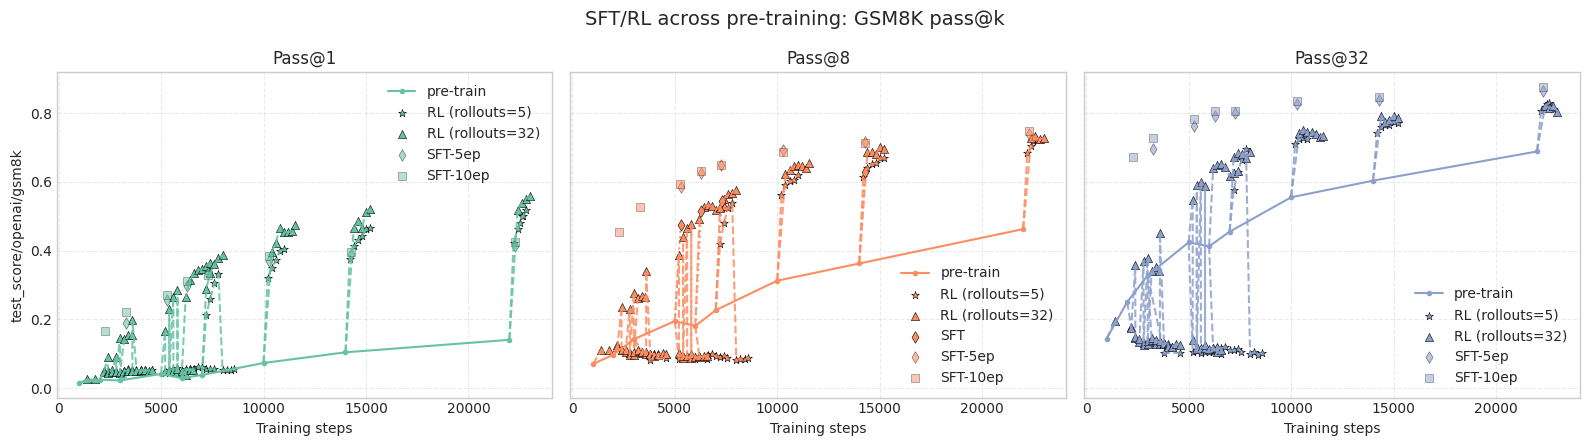

In [9]:
# Refined plotting: per-k subplots, cleaner legend markers, no RL/SFT marker at start
PLOT_SAMPLES = [1, 8, 32]
BASE_PRETRAIN_SHOT = 8
SHOT_BY_SAMPLES = lambda s: BASE_PRETRAIN_SHOT
TEMP_BY_SAMPLES = lambda s: 0.6

available_samples = sorted(set(pre_df["samples"]).union(rl_df["samples"]).union(sft_df["samples"]))
plot_samples = [s for s in PLOT_SAMPLES if s in available_samples]

plt.style.use("seaborn-v0_8-whitegrid")

if not plot_samples:
    fig, ax = plt.subplots(figsize=(20, 14))
    ax.text(0.5, 0.5, "No runs for the selected samples/temp", transform=ax.transAxes, ha="center")
    plt.show()
else:
    n = len(plot_samples)
    ncols = n  # 2 if n > 1 else 1
    nrows = 1  # (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 4.5 * nrows), sharey=True)
    axes = axes.flatten() if n > 1 else [axes]
    cmap = plt.get_cmap("Set2")

    for idx, samples in enumerate(plot_samples):
        ax = axes[idx]
        target_temp = TEMP_BY_SAMPLES(samples)
        shot = SHOT_BY_SAMPLES(samples)
        color = cmap(idx % cmap.N)

        pre_curve = pre_df[(pre_df["samples"] == samples) & (pre_df["shot"] == shot) & (pre_df["temp"] == target_temp)].sort_values("step")
        if not pre_curve.empty:
            ax.plot(pre_curve["step"], pre_curve["score"], marker=".", color=color, label="pre-train")

        # RL: plot different curves for each num_rollouts
        rl_all = rl_df[(rl_df["samples"] == samples) & (rl_df["temp"] == target_temp)].sort_values(["num_rollouts", "pt_step", "rl_step"])
        unique_num_rollouts = sorted(rl_all["num_rollouts"].dropna().unique())
        # from matplotlib.cm import get_cmap
        # rl_cmap = get_cmap("tab10")
        for j, num_rollouts in enumerate(unique_num_rollouts):
            # subcolor = rl_cmap(j % rl_cmap.N)
            subset = rl_all[rl_all["num_rollouts"] == num_rollouts]
            rl_labeled = False
            for pt_step, group in subset.groupby("pt_step"):
                pre_match = pre_curve.loc[pre_curve["step"] == pt_step, "score"]
                start_score = pre_match.iloc[0] if not pre_match.empty else None
                group_sorted = group.sort_values("rl_step")
                xs = [pt_step] if start_score is not None else []
                ys = [start_score] if start_score is not None else []
                xs.extend((group_sorted["pt_step"] + group_sorted["rl_step"]).tolist())
                ys.extend(group_sorted["score"].tolist())
                if not xs:
                    continue
                label_rl = f"RL (rollouts={num_rollouts})" if not rl_labeled else None
                ax.plot(xs, ys, linestyle="--", marker=None, color=color, alpha=0.85)
                if len(xs) > 1:
                    ax.scatter(xs[1:], ys[1:], marker="*" if num_rollouts == 5 else "^", color=color, s=35, edgecolor="k", linewidth=0.4, label=label_rl)
                    rl_labeled = True

        # SFT standard (1 epoch)
        sft_curve = sft_df[(sft_df.get("sft_epochs", "sft") == 1) & (sft_df["samples"] == samples) & (sft_df["temp"] == target_temp)].sort_values(["pt_step", "sft_step"])
        sft_labeled = False
        for pt_step, group in sft_curve.groupby("pt_step"):
            pre_match = pre_curve.loc[pre_curve["step"] == pt_step, "score"]
            start_score = pre_match.iloc[0] if not pre_match.empty else None
            group_sorted = group.sort_values("sft_step")
            xs = [pt_step] if start_score is not None else []
            ys = [start_score] if start_score is not None else []
            xs.extend((group_sorted["pt_step"] + group_sorted["sft_step"]).tolist())
            ys.extend(group_sorted["score"].tolist())
            if not xs:
                continue
            ax.plot(xs, ys, linestyle=":", marker=None, color=color, alpha=0.9)
            if len(xs) > 1:
                ax.scatter(xs[1:], ys[1:], marker="d", color=color, s=35, edgecolor="k", linewidth=0.4, label="SFT" if not sft_labeled else None)
                sft_labeled = True

        # SFT 5-epoch
        sft5_curve = sft_df[(sft_df.get("sft_epochs", "sft") == 5) & (sft_df["samples"] == samples) & (sft_df["temp"] == target_temp)].sort_values(["pt_step", "sft_step"])
        sft5_labeled = False
        for pt_step, group in sft5_curve.groupby("pt_step"):
            pre_match = pre_curve.loc[pre_curve["step"] == pt_step, "score"]
            start_score = pre_match.iloc[0] if not pre_match.empty else None
            group_sorted = group.sort_values("sft_step")
            xs = [pt_step] if start_score is not None else []
            ys = [start_score] if start_score is not None else []
            xs.extend((group_sorted["pt_step"] + group_sorted["sft_step"]).tolist())
            xs = [(pt_step + (x - pt_step)//5) for x in xs]
            ys.extend(group_sorted["score"].tolist())
            if not xs:
                continue
            # ax.plot(xs, ys, linestyle="-.", marker=None, color=color, alpha=0.9)
            if len(xs) > 1:
                ax.scatter(xs[1:], ys[1:], marker="d", color=color, s=35, edgecolor="k", linewidth=0.4, label="SFT-5ep" if not sft5_labeled else None, alpha=0.6)
                sft5_labeled = True

        # SFT 10-epoch
        sft10_curve = sft_df[(sft_df.get("sft_epochs", "sft") == 10) & (sft_df["samples"] == samples) & (sft_df["temp"] == target_temp)].sort_values(["pt_step", "sft_step"])
        sft10_labeled = False
        for pt_step, group in sft10_curve.groupby("pt_step"):
            pre_match = pre_curve.loc[pre_curve["step"] == pt_step, "score"]
            start_score = pre_match.iloc[0] if not pre_match.empty else None
            group_sorted = group.sort_values("sft_step")
            xs = [pt_step] if start_score is not None else []
            ys = [start_score] if start_score is not None else []
            xs.extend((group_sorted["pt_step"] + group_sorted["sft_step"]).tolist())
            xs = [(pt_step + (x - pt_step)//10) for x in xs]
            ys.extend(group_sorted["score"].tolist())
            if not xs:
                continue
            # ax.plot(xs, ys, linestyle="-.", marker=None, color=color, alpha=0.9)
            if len(xs) > 1:
                ax.scatter(xs[1:], ys[1:], marker="s", color=color, s=35, edgecolor="k", linewidth=0.4, label="SFT-10ep" if not sft10_labeled else None, alpha=0.5)
                sft10_labeled = True

        ax.set_title(f"Pass@{samples}")
        ax.set_xlabel("Training steps")
        if idx % ncols == 0:
            ax.set_ylabel(DATASET_KEY)
        ax.grid(True, linestyle="--", alpha=0.4)
        ax.legend()

    fig.suptitle(f"SFT/RL across pre-training: GSM8K pass@k", fontsize=14)
    plt.tight_layout()
    plt.show()

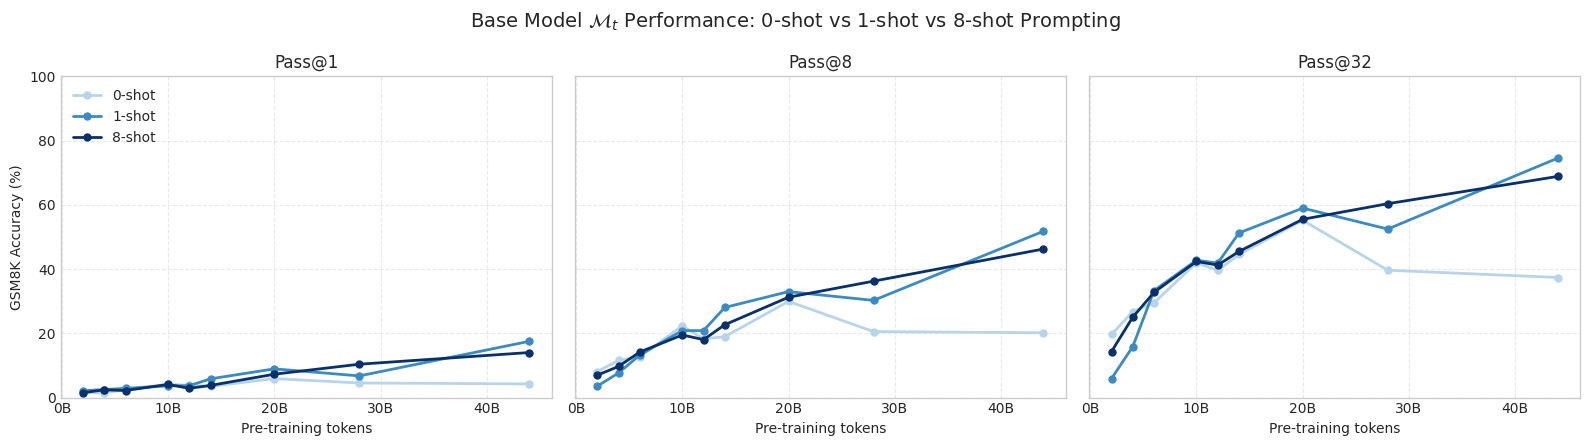

In [10]:
# Plot 1: Base model performance comparison - 0-shot vs 1-shot vs 8-shot for pass@1, pass@8, pass@32
PLOT_SAMPLES_BASE = [1, 8, 32]
SHOT_COMPARISON = [0, 1, 8]
TARGET_TEMP = 0.6
TOKENS_PER_STEP = 2_000_000  # 2M tokens per step

fig, axes = plt.subplots(1, 3, figsize=(16, 4.5), sharey=True)
cmap = plt.get_cmap("Blues")

for idx, samples in enumerate(PLOT_SAMPLES_BASE):
    ax = axes[idx]

    for shot_idx, shot in enumerate(SHOT_COMPARISON):
        # Color gradient: lighter for 0-shot, darker for 8-shot
        color = cmap(0.3 + 0.7 * shot_idx / (len(SHOT_COMPARISON) - 1))

        # Filter pre-train data for this samples/shot/temp combination
        pre_curve = pre_df[
            (pre_df["samples"] == samples) &
            (pre_df["shot"] == shot) &
            (pre_df["temp"] == TARGET_TEMP)
        ].sort_values("step")

        if not pre_curve.empty:
            tokens_billions = pre_curve["step"] * TOKENS_PER_STEP / 1e9
            ax.plot(
                tokens_billions,
                pre_curve["score"] * 100,
                marker="o",
                markersize=5,
                color=color,
                label=f"{shot}-shot",
                linewidth=2
            )

    ax.set_title(f"Pass@{samples}", fontsize=12)
    ax.set_xlabel("Pre-training tokens")
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:g}B"))
    if idx == 0:
        ax.set_ylabel("GSM8K Accuracy (%)")
    ax.set_ylim(0, 100)
    ax.grid(True, linestyle="--", alpha=0.4)
    if idx == 0:
        ax.legend(loc="upper left")

fig.suptitle(r"Base Model $\mathcal{M}_t$ Performance: 0-shot vs 1-shot vs 8-shot Prompting", fontsize=14)
plt.tight_layout()
fig.savefig("/n/home05/sqin/rl_pretrain/verl/notebooks/gsm8k_base_eval_shots.pdf", bbox_inches="tight")
plt.show() 

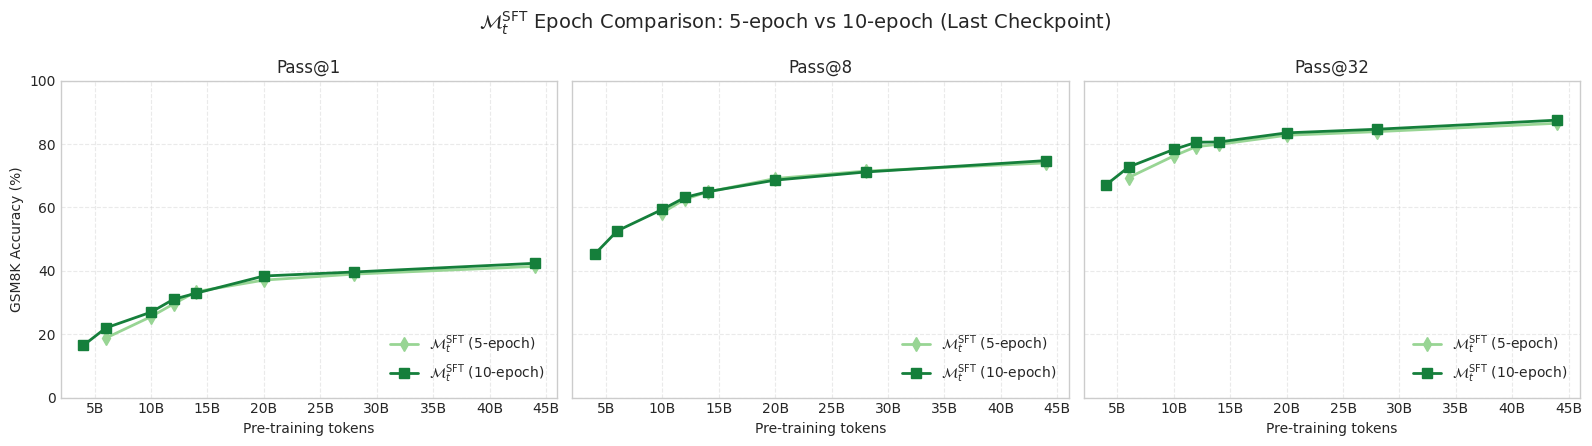

In [11]:
# Plot 2: SFT epoch comparison - 5-epoch vs 10-epoch (last checkpoint for each)
# X-axis is pre-training tokens, different shades of green for each epoch count
PLOT_SAMPLES_BASE = [1, 8, 32]
TARGET_TEMP = 0.6
SFT_EPOCH_COMPARISON = [5, 10]
TOKENS_PER_STEP = 2_000_000  # 2M tokens per step

fig, axes = plt.subplots(1, 3, figsize=(16, 4.5), sharey=True)
green_cmap = plt.get_cmap("Greens")

for idx, samples in enumerate(PLOT_SAMPLES_BASE):
    ax = axes[idx]

    for epoch_idx, epochs in enumerate(SFT_EPOCH_COMPARISON):
        # Color gradient: lighter for 5-epoch, darker for 10-epoch
        color = green_cmap(0.4 + 0.4 * epoch_idx / (len(SFT_EPOCH_COMPARISON) - 1))

        # Filter SFT data for this samples/temp/epochs combination
        sft_subset = sft_df[
            (sft_df["samples"] == samples) &
            (sft_df["temp"] == TARGET_TEMP) &
            (sft_df["sft_epochs"] == epochs)
        ]

        # Get the last sft_step for each pt_step
        if not sft_subset.empty:
            sft_last = sft_subset.loc[sft_subset.groupby("pt_step")["sft_step"].idxmax()]
            sft_last = sft_last.sort_values("pt_step")
            tokens_billions = sft_last["pt_step"] * TOKENS_PER_STEP / 1e9
            ax.plot(
                tokens_billions,
                sft_last["score"] * 100,
                marker="d" if epochs == 5 else "s",
                markersize=7,
                color=color,
                label=r"$\mathcal{M}_t^{\mathrm{SFT}}$" + f" ({epochs}-epoch)",
                linewidth=2
            )

    ax.set_title(f"Pass@{samples}", fontsize=12)
    ax.set_xlabel("Pre-training tokens")
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:g}B"))
    if idx == 0:
        ax.set_ylabel("GSM8K Accuracy (%)")
    ax.set_ylim(0, 100)
    ax.grid(True, linestyle="--", alpha=0.4)
    ax.legend(loc="lower right")

fig.suptitle(r"$\mathcal{M}_t^{\mathrm{SFT}}$ Epoch Comparison: 5-epoch vs 10-epoch (Last Checkpoint)", fontsize=14)
plt.tight_layout()
fig.savefig("/n/home05/sqin/rl_pretrain/verl/notebooks/gsm8k_sft_epoch_comparison.pdf", bbox_inches="tight")
plt.show()

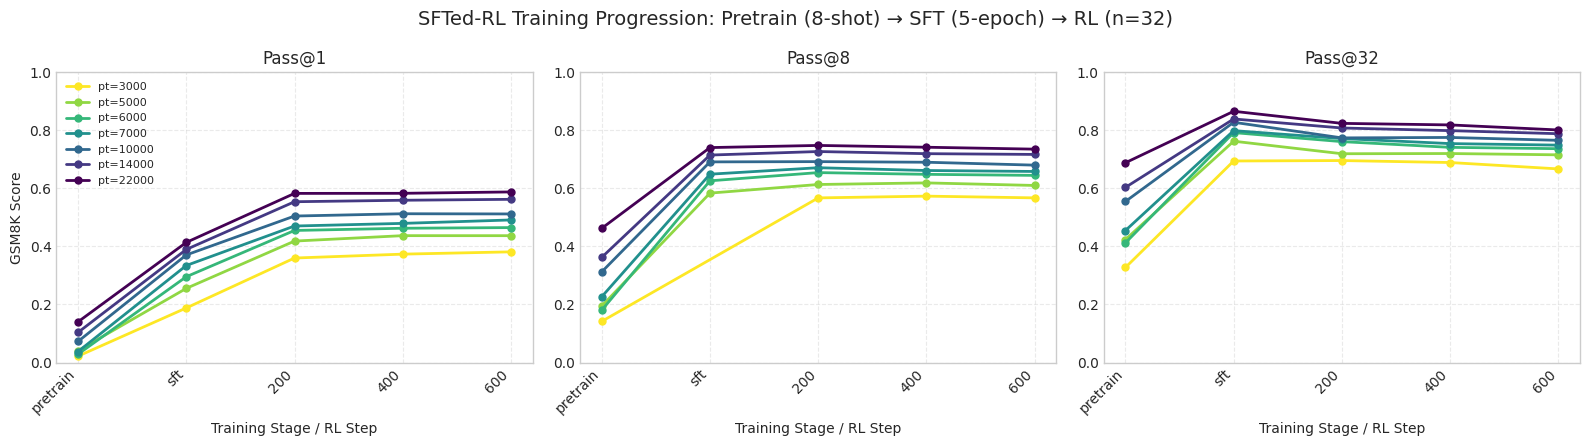

In [12]:
# Plot 3: SFTed-RL Training Progression - Pretrain → SFT → RL steps
# X-axis: "pretrain" (8-shot) → "sft" (5-epoch) → rl_step1 → rl_step2 → ...
# One line per pretraining checkpoint
TARGET_TEMP = 0.6
TARGET_SHOT = 8
SFT_EPOCHS = 5
SFTED_RL_ROLLOUTS = 32
PLOT_SAMPLES = [1, 8, 32]

fig, axes = plt.subplots(1, 3, figsize=(16, 4.5), sharey=False)
cmap = plt.get_cmap("viridis_r")

# Get unique pt_steps from sfted_rl_df
pt_steps_sfted = sorted(sfted_rl_df["pt_step"].unique()) if not sfted_rl_df.empty else []
n_steps = len(pt_steps_sfted)

for idx, samples in enumerate(PLOT_SAMPLES):
    ax = axes[idx]
    
    for i, pt_step in enumerate(pt_steps_sfted):
        color = cmap(i / (n_steps - 1) if n_steps > 1 else 0.5)
        
        # 1. Get pretrain score (8-shot)
        pre_score_row = pre_df[
            (pre_df["step"] == pt_step) &
            (pre_df["samples"] == samples) &
            (pre_df["shot"] == TARGET_SHOT) &
            (pre_df["temp"] == TARGET_TEMP)
        ]
        pre_score = pre_score_row.iloc[0]["score"] if not pre_score_row.empty else None
        
        # 2. Get SFT score (5-epoch, last checkpoint)
        sft_subset = sft_df[
            (sft_df["pt_step"] == pt_step) &
            (sft_df["samples"] == samples) &
            (sft_df["temp"] == TARGET_TEMP) &
            (sft_df["sft_epochs"] == SFT_EPOCHS)
        ]
        if not sft_subset.empty:
            sft_last = sft_subset.loc[sft_subset["sft_step"].idxmax()]
            sft_score = sft_last["score"]
        else:
            sft_score = None
        
        # 3. Get SFTed-RL scores
        sfted_rl_subset = sfted_rl_df[
            (sfted_rl_df["pt_step"] == pt_step) &
            (sfted_rl_df["samples"] == samples) &
            (sfted_rl_df["temp"] == TARGET_TEMP) &
            (sfted_rl_df["num_rollouts"] == SFTED_RL_ROLLOUTS)
        ].sort_values("rl_step")
        
        # Build x and y arrays
        # x positions: 0 = pretrain, 1 = sft, 2+ = rl steps
        xs = []
        ys = []
        x_labels = []
        
        if pre_score is not None:
            xs.append(0)
            ys.append(pre_score)
            x_labels.append("pretrain")
        
        if sft_score is not None:
            xs.append(1)
            ys.append(sft_score)
            x_labels.append("sft")
        
        # Add RL steps
        if not sfted_rl_subset.empty:
            rl_steps = sorted(sfted_rl_subset["rl_step"].unique())
            for j, rl_step in enumerate(rl_steps):
                rl_row = sfted_rl_subset[sfted_rl_subset["rl_step"] == rl_step].iloc[0]
                xs.append(2 + j)
                ys.append(rl_row["score"])
                x_labels.append(str(rl_step))
        
        if xs:
            ax.plot(xs, ys, marker="o", markersize=5, color=color, 
                    label=f"pt={pt_step}", linewidth=2)
    
    # Set x-axis ticks and labels
    # Collect all unique x positions across all lines
    all_x_positions = [0, 1]  # pretrain, sft
    if not sfted_rl_df.empty:
        all_rl_steps = sorted(sfted_rl_df[
            (sfted_rl_df["samples"] == samples) &
            (sfted_rl_df["temp"] == TARGET_TEMP) &
            (sfted_rl_df["num_rollouts"] == SFTED_RL_ROLLOUTS)
        ]["rl_step"].unique())
        all_x_positions.extend([2 + j for j in range(len(all_rl_steps))])
        x_tick_labels = ["pretrain", "sft"] + [str(s) for s in all_rl_steps]
    else:
        x_tick_labels = ["pretrain", "sft"]
    
    ax.set_xticks(all_x_positions)
    ax.set_xticklabels(x_tick_labels, rotation=45, ha="right")
    
    ax.set_title(f"Pass@{samples}", fontsize=12)
    ax.set_xlabel("Training Stage / RL Step")
    if idx == 0:
        ax.set_ylabel("GSM8K Score")
    ax.set_ylim(0, 1.0)
    ax.grid(True, linestyle="--", alpha=0.4)
    if idx == 0:
        ax.legend(loc="upper left", fontsize=8)

fig.suptitle(f"SFTed-RL Training Progression: Pretrain (8-shot) → SFT (5-epoch) → RL (n={SFTED_RL_ROLLOUTS})", fontsize=14)
plt.tight_layout()
plt.show()

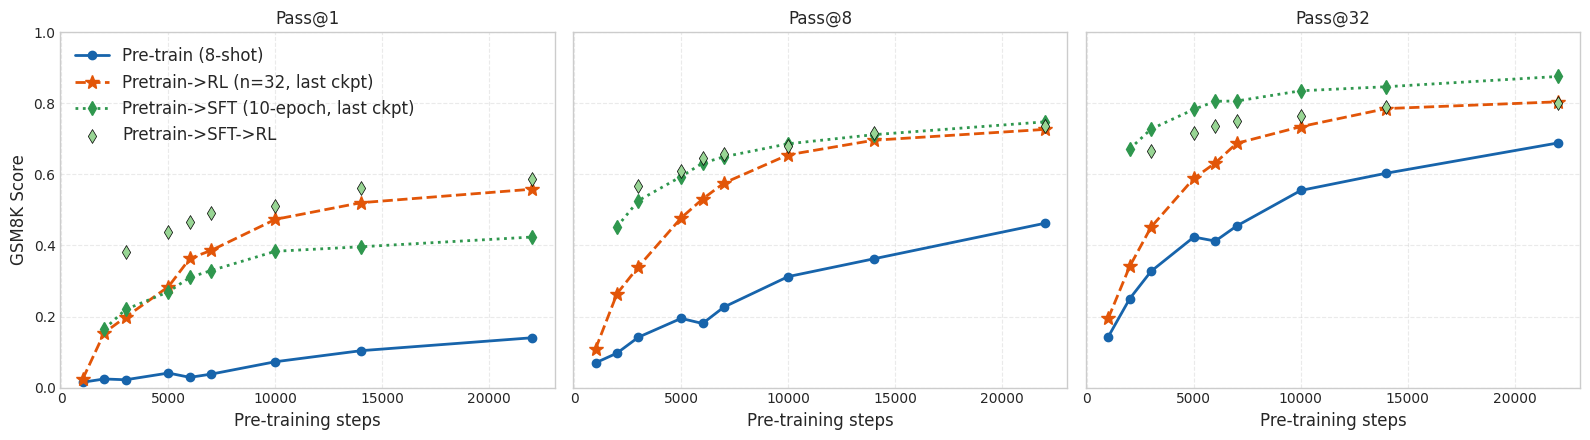

In [13]:
# Plot 4: Base model (8-shot) vs RL (rollout=32, last ckpt) vs SFT (10-epoch, last ckpt) vs SFT->RL
# X-axis is pt_step for all, different markers and colors for each method
PLOT_SAMPLES_BASE = [1, 8, 32]
TARGET_TEMP = 0.6
TARGET_SHOT = 8
RL_ROLLOUTS = 32
SFT_EPOCHS = 10
SFTED_RL_ROLLOUTS = 32

fig, axes = plt.subplots(1, 3, figsize=(16, 4.5), sharey=True)

# Different color families for each method
pretrain_color = plt.get_cmap("Blues")(0.8)
rl_color = plt.get_cmap("Oranges")(0.7)
sft_color = plt.get_cmap("Greens")(0.7)
sfted_rl_color = plt.get_cmap("Greens")(0.4)  # Light green for SFT->RL

for idx, samples in enumerate(PLOT_SAMPLES_BASE):
    ax = axes[idx]

    # Pre-train (8-shot) - circle markers
    pre_curve = pre_df[
        (pre_df["samples"] == samples) &
        (pre_df["shot"] == TARGET_SHOT) &
        (pre_df["temp"] == TARGET_TEMP)
    ].sort_values("step")

    if not pre_curve.empty:
        ax.plot(
            pre_curve["step"],
            pre_curve["score"],
            marker="o",
            markersize=6,
            color=pretrain_color,
            label="Pre-train (8-shot)",
            linewidth=2
        )

    # RL (rollout=32, last checkpoint per pt_step, best seed) - star markers
    rl_subset = rl_df[
        (rl_df["samples"] == samples) &
        (rl_df["temp"] == TARGET_TEMP) &
        (rl_df["num_rollouts"] == RL_ROLLOUTS)
    ]
    # Get the last rl_step for each (pt_step, seed), then pick the best seed per pt_step
    if not rl_subset.empty:
        # First get the last rl_step for each (pt_step, seed) combination
        rl_last_per_seed = rl_subset.loc[rl_subset.groupby(["pt_step", "seed"])["rl_step"].idxmax()]
        # Then for each pt_step, pick the seed with the max score
        rl_last = rl_last_per_seed.loc[rl_last_per_seed.groupby("pt_step")["score"].idxmax()]
        rl_last = rl_last.sort_values("pt_step")
        ax.plot(
            rl_last["pt_step"],
            rl_last["score"],
            marker="*",
            markersize=10,
            color=rl_color,
            label=f"Pretrain->RL (n={RL_ROLLOUTS}, last ckpt)",
            linewidth=2,
            linestyle="--"
        )

    # SFT (10-epoch, last checkpoint per pt_step) - diamond markers
    sft_subset = sft_df[
        (sft_df["samples"] == samples) &
        (sft_df["temp"] == TARGET_TEMP) &
        (sft_df["sft_epochs"] == SFT_EPOCHS)
    ]
    # Get the last sft_step for each pt_step
    if not sft_subset.empty:
        sft_last = sft_subset.loc[sft_subset.groupby("pt_step")["sft_step"].idxmax()]
        sft_last = sft_last.sort_values("pt_step")
        ax.plot(
            sft_last["pt_step"],
            sft_last["score"],
            marker="d",
            markersize=7,
            color=sft_color,
            label=f"Pretrain->SFT ({SFT_EPOCHS}-epoch, last ckpt)",
            linewidth=2,
            linestyle=":"
        )

    # SFT->RL (last checkpoint per pt_step) - light green diamond markers, no connecting line
    sfted_rl_subset = sfted_rl_df[
        (sfted_rl_df["samples"] == samples) &
        (sfted_rl_df["temp"] == TARGET_TEMP) &
        (sfted_rl_df["num_rollouts"] == SFTED_RL_ROLLOUTS)
    ]
    # Get the last rl_step for each pt_step
    if not sfted_rl_subset.empty:
        sfted_rl_last = sfted_rl_subset.loc[sfted_rl_subset.groupby("pt_step")["rl_step"].idxmax()]
        sfted_rl_last = sfted_rl_last.sort_values("pt_step")
        ax.scatter(
            sfted_rl_last["pt_step"],
            sfted_rl_last["score"],
            marker="d",
            s=50,
            color=sfted_rl_color,
            label="Pretrain->SFT->RL",
            edgecolor="k",
            linewidth=0.5,
            zorder=5
        )

    ax.set_title(f"Pass@{samples}", fontsize=12)
    ax.set_xlabel("Pre-training steps", fontsize=12)
    if idx == 0:
        ax.set_ylabel("GSM8K Score", fontsize=12)
    ax.set_ylim(0, 1.0)
    ax.grid(True, linestyle="--", alpha=0.4)
    if idx == 0:
        ax.legend(loc="upper left", fontsize=12)

# fig.suptitle("Pre-train vs RL vs SFT vs SFT->RL: Final Checkpoint Performance by Pre-train Step", fontsize=14)
plt.tight_layout()
plt.show()

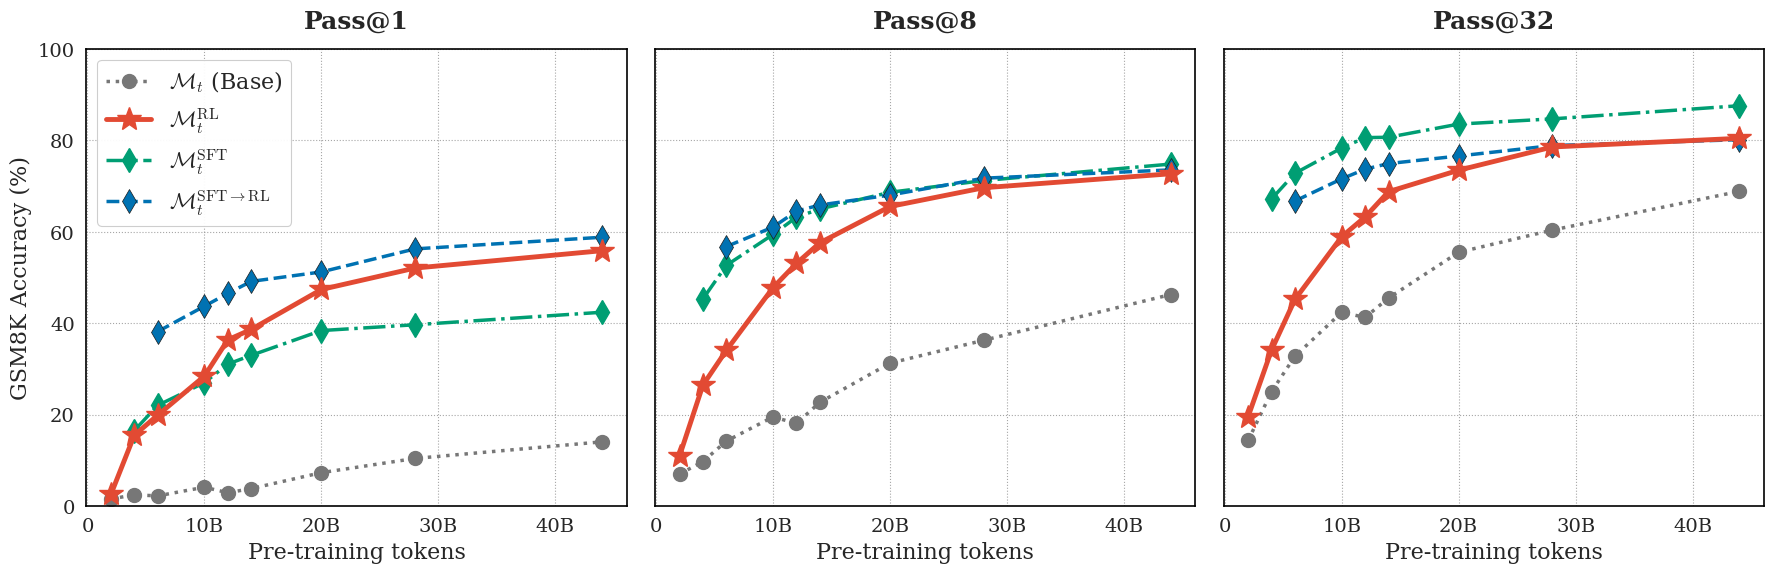

In [16]:
import seaborn as sns
from matplotlib.ticker import FuncFormatter
# 1. Setup Theme
sns.set_theme(style="whitegrid", context="paper", font_scale=1.6)

plt.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "axes.titlesize": 18,
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "axes.edgecolor": "black",
    "axes.linewidth": 1.2,
})

# Constants
PLOT_SAMPLES_BASE = [1, 8, 32]
TARGET_TEMP = 0.6
TARGET_SHOT = 8
RL_ROLLOUTS = 32
SFT_EPOCHS = 10
SFTED_RL_ROLLOUTS = 32
TOKEN_MULTIPLIER = 2_000_000

# 2. COLOR PALETTE (Okabe-Ito / High Contrast)
color_base = "#777777"     # Gray
color_rl = "#E24A33"       # Red
color_sft = "#009E73"      # Emerald Green
color_sfted_rl = "#0072B2" # Royal Blue

# 3. Styles
styles = {
    "pretrain": {
        "color": color_base, 
        "marker": "o", "ls": ":", "markersize": 10,
        "linewidth": 2.5,
        "label": r"$\mathcal{M}_t$ (Base)"
    },
    "sft": {
        "color": color_sft, 
        "marker": "d", "ls": "-.", "markersize": 12,
        "linewidth": 2.5,
        "label": r"$\mathcal{M}_t^{\text{SFT}}$"
    },
    "sfted_rl": {
        "color": color_sfted_rl, 
        "marker": "d", "ls": "--", "markersize": 12,
        "linewidth": 2.5,
        "label": r"$\mathcal{M}_t^{\text{SFT} \rightarrow \text{RL}}$"
    },
    "rl": {
        "color": color_rl, 
        "marker": "*", "ls": "-", "markersize": 18,
        "linewidth": 3.5,
        "label": r"$\mathcal{M}_t^{\text{RL}}$"
    }
}

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# X-axis formatter
def human_format(num, pos):
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '%.0f%s' % (num, ['', 'K', 'M', 'B', 'T'][magnitude])
formatter = FuncFormatter(human_format)

for idx, samples in enumerate(PLOT_SAMPLES_BASE):
    ax = axes[idx]

    # --- Plotting Series ---
    
    # 1. Base
    pre_curve = pre_df[(pre_df["samples"] == samples) & (pre_df["shot"] == TARGET_SHOT) & (pre_df["temp"] == TARGET_TEMP)].sort_values("step")
    if not pre_curve.empty:
        ax.plot(pre_curve["step"] * TOKEN_MULTIPLIER, pre_curve["score"] * 100, **styles["pretrain"])

    # 2. SFT
    sft_subset = sft_df[(sft_df["samples"] == samples) & (sft_df["temp"] == TARGET_TEMP) & (sft_df["sft_epochs"] == SFT_EPOCHS)]
    if not sft_subset.empty:
        sft_last = sft_subset.loc[sft_subset.groupby("pt_step")["sft_step"].idxmax()].sort_values("pt_step")
        ax.plot(sft_last["pt_step"] * TOKEN_MULTIPLIER, sft_last["score"] * 100, **styles["sft"])

    # 3. SFT -> RL
    sfted_rl_subset = sfted_rl_df[(sfted_rl_df["samples"] == samples) & (sfted_rl_df["temp"] == TARGET_TEMP) & (sfted_rl_df["num_rollouts"] == SFTED_RL_ROLLOUTS)]
    if not sfted_rl_subset.empty:
        sfted_rl_last = sfted_rl_subset.loc[sfted_rl_subset.groupby("pt_step")["rl_step"].idxmax()].sort_values("pt_step")
        ax.plot(sfted_rl_last["pt_step"] * TOKEN_MULTIPLIER, sfted_rl_last["score"] * 100, **styles["sfted_rl"], markeredgecolor="k", markeredgewidth=0.5)

    # 4. RL Only
    rl_subset = rl_df[(rl_df["samples"] == samples) & (rl_df["temp"] == TARGET_TEMP) & (rl_df["num_rollouts"] == RL_ROLLOUTS)]
    if not rl_subset.empty:
        rl_last = rl_subset.loc[rl_subset.groupby(["pt_step", "seed"])["rl_step"].idxmax()].sort_values("pt_step")
        rl_last = rl_last.loc[rl_last.groupby("pt_step")["score"].idxmax()]
        ax.plot(rl_last["pt_step"] * TOKEN_MULTIPLIER, rl_last["score"] * 100, **styles["rl"], zorder=10)

    # --- Formatting ---
    ax.set_title(f"Pass@{samples}", fontweight="bold", pad=15)
    ax.set_xlabel("Pre-training tokens")
    ax.xaxis.set_major_formatter(formatter)

    if idx == 0:
        ax.set_ylabel("GSM8K Accuracy (%)")
        
        # --- Legend Sorting ---
        handles, labels = ax.get_legend_handles_labels()
        desired_order = [
            styles["pretrain"]["label"],
            styles["rl"]["label"],
            styles["sft"]["label"],
            styles["sfted_rl"]["label"]
        ]
        order_lookup = {label: i for i, label in enumerate(desired_order)}
        sorted_pairs = sorted(zip(handles, labels), key=lambda pair: order_lookup.get(pair[1], 99))
        sorted_handles, sorted_labels = zip(*sorted_pairs)
        
        ax.legend(sorted_handles, sorted_labels, frameon=True, framealpha=0.95, loc="upper left", fontsize=16)
    
    ax.set_ylim(0, 100)
    
    # --- Darker Grid Lines ---
    ax.grid(True, linestyle=":", color="gray", alpha=0.7)

    # Full Borders
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_edgecolor('black')
        spine.set_linewidth(1.2)

plt.tight_layout()
fig.savefig("/n/home05/sqin/rl_pretrain/verl/notebooks/gsm8k_rl_sft_comparison.pdf", bbox_inches="tight")
plt.show()

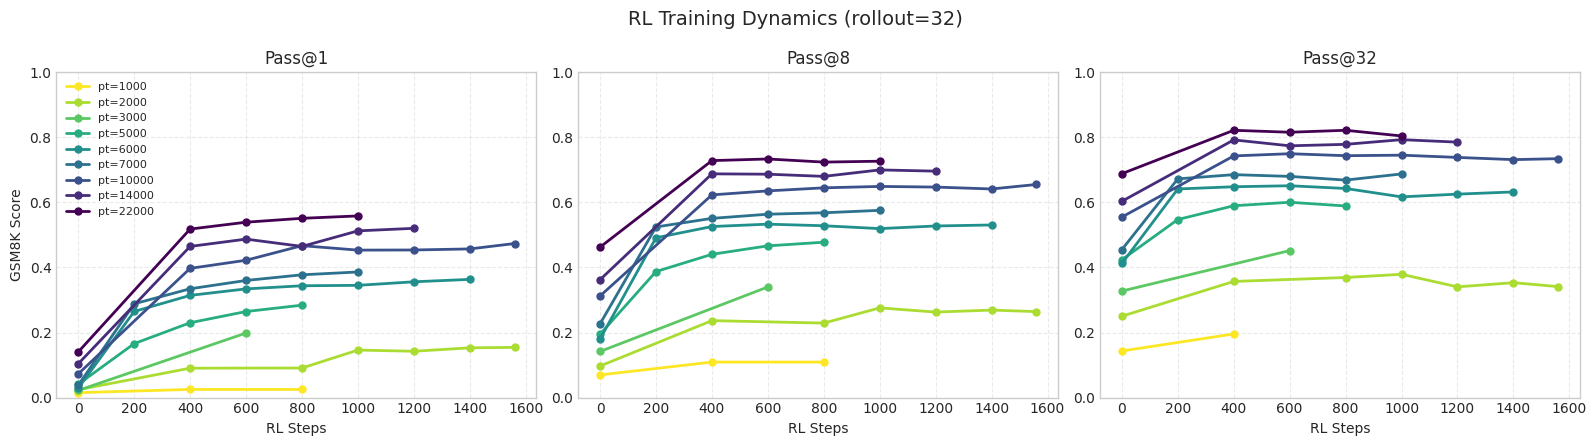

In [14]:
# Plot 5: RL training dynamics (rollout=32) - Pass@1, Pass@8, Pass@32
# X-axis is rl_step, one line per pt_step
# rl_step=0 uses the corresponding pre-train model 8-shot performance
# For each pt_step, plot only the seed with the best final performance
TARGET_TEMP = 0.6
TARGET_SHOT = 8
RL_ROLLOUTS = 32
PLOT_SAMPLES = [1, 8, 32]

fig, axes = plt.subplots(1, 3, figsize=(16, 4.5), sharey=False)
cmap = plt.get_cmap("viridis_r")

for idx, samples in enumerate(PLOT_SAMPLES):
    ax = axes[idx]

    # Filter RL data for rollout=32, this pass@k
    rl_subset = rl_df[
        (rl_df["samples"] == samples) &
        (rl_df["temp"] == TARGET_TEMP) &
        (rl_df["num_rollouts"] == RL_ROLLOUTS)
    ]

    if rl_subset.empty:
        continue

    # For each pt_step, find the seed with the best final performance
    # Step 1: Get the last rl_step for each (pt_step, seed)
    last_step_idx = rl_subset.groupby(["pt_step", "seed"])["rl_step"].idxmax()
    last_step_scores = rl_subset.loc[last_step_idx]
    # Step 2: For each pt_step, pick the seed with max score at its last step
    best_seed_idx = last_step_scores.groupby("pt_step")["score"].idxmax()
    best_seeds = last_step_scores.loc[best_seed_idx][["pt_step", "seed"]]
    
    # Filter rl_subset to only include the best seed for each pt_step
    rl_subset = rl_subset.merge(best_seeds, on=["pt_step", "seed"], how="inner")
    rl_subset = rl_subset.sort_values(["pt_step", "rl_step"])

    # Get unique pt_steps and assign colors
    pt_steps = sorted(rl_subset["pt_step"].unique())
    n_steps = len(pt_steps)

    for i, pt_step in enumerate(pt_steps):
        color = cmap(i / (n_steps - 1) if n_steps > 1 else 0.5)
        subset = rl_subset[rl_subset["pt_step"] == pt_step].sort_values("rl_step")

        if not subset.empty:
            # Get pre-train score for rl_step=0
            pre_score = pre_df[
                (pre_df["step"] == pt_step) &
                (pre_df["samples"] == samples) &
                (pre_df["shot"] == TARGET_SHOT) &
                (pre_df["temp"] == TARGET_TEMP)
            ]
            
            # Build x and y arrays, starting with rl_step=0 if pre-train data exists
            if not pre_score.empty:
                xs = [0] + subset["rl_step"].tolist()
                ys = [pre_score.iloc[0]["score"]] + subset["score"].tolist()
            else:
                xs = subset["rl_step"].tolist()
                ys = subset["score"].tolist()

            ax.plot(
                xs,
                ys,
                marker="o",
                markersize=5,
                color=color,
                label=f"pt={pt_step}",
                linewidth=2
            )

    ax.set_title(f"Pass@{samples}", fontsize=12)
    ax.set_xlabel("RL Steps")
    if idx == 0:
        ax.set_ylabel("GSM8K Score")
    ax.set_ylim(0, 1.0)
    ax.grid(True, linestyle="--", alpha=0.4)
    if idx == 0:
        ax.legend(loc="upper left", fontsize=8)

fig.suptitle(f"RL Training Dynamics (rollout={RL_ROLLOUTS})", fontsize=14)
plt.tight_layout()
plt.show()

Found pt_steps: [1000, 2000, 3000, 5000, 6000, 7000, 10000, 14000, 22000]


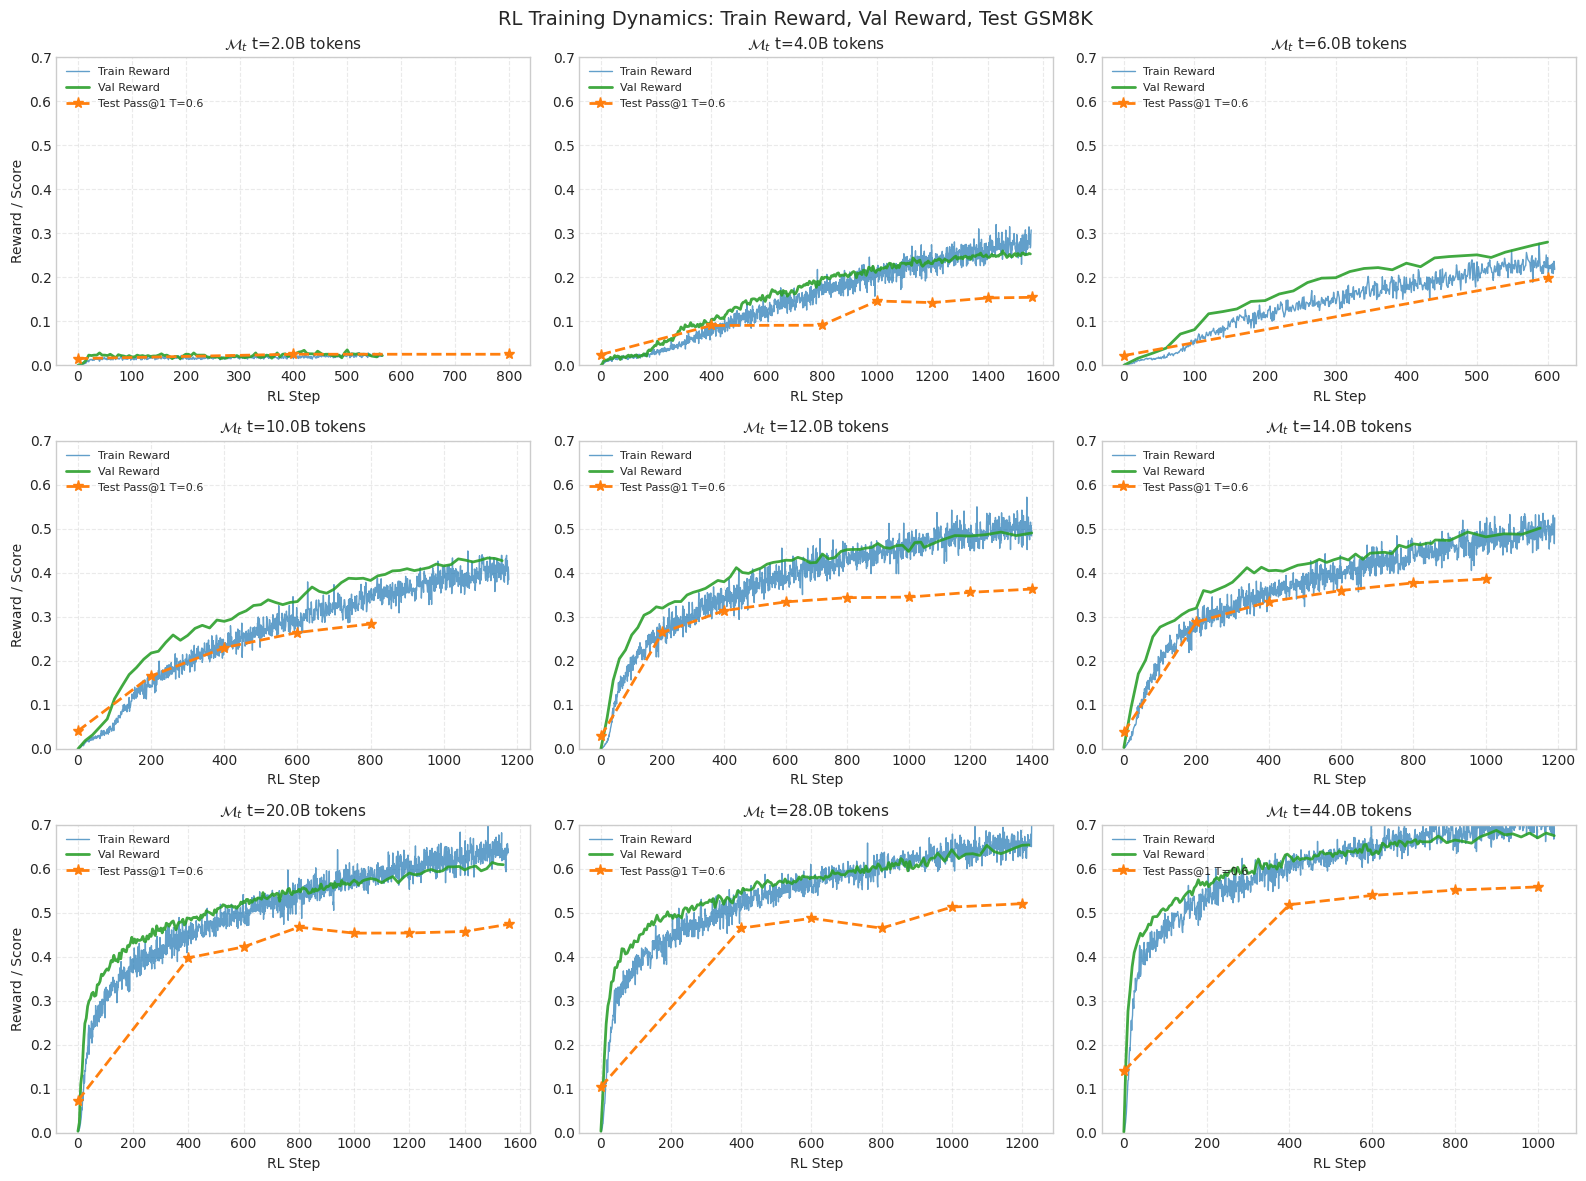

In [15]:
# Plot 6: RL Training Dynamics - 3x3 grid for each pt_step (using combined CSV files)
# Each subplot shows: (1) training reward, (2) validation reward, (3) test GSM8K performance
# For test performance, pick the seed with the best final performance
import os

RESULT_FILES_DIR = "/n/home05/sqin/rl_pretrain/verl/notebooks/result_files"
TRAIN_CSV = os.path.join(RESULT_FILES_DIR, "stepsall_omigsm8k_n32_train_reward.csv")
VAL_CSV = os.path.join(RESULT_FILES_DIR, "stepsall_omigsm8k_n32_val_reward.csv")
TARGET_TEMP = 0.6
TARGET_SHOT = 8
RL_ROLLOUTS = 32
TARGET_SAMPLES = 1  # pass@1 for test performance

# Load the combined CSVs
train_all_df = pd.read_csv(TRAIN_CSV)
val_all_df = pd.read_csv(VAL_CSV)

# Extract pt_steps from column headers (format: ".../step{pt_step}-hf - ...")
def extract_pt_steps_from_columns(df, pattern=r"step(\d+)-hf"):
    pt_steps = set()
    for col in df.columns:
        match = re.search(pattern, col)
        if match:
            pt_steps.add(int(match.group(1)))
    return sorted(pt_steps)

pt_steps_from_files = extract_pt_steps_from_columns(val_all_df)
print(f"Found pt_steps: {pt_steps_from_files}")

def pt_step_to_billions(pt_step):
    """Convert pretraining step to billions of tokens (each step = 2M tokens)."""
    return pt_step * 2 / 1000

# Create 3x3 grid
n_steps = len(pt_steps_from_files)
nrows = 3
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 12), sharey=False)
axes = axes.flatten()

for idx, pt_step in enumerate(pt_steps_from_files):
    if idx >= nrows * ncols:
        break
    ax = axes[idx]
    
    # Find columns for this pt_step
    train_col = None
    val_col = None
    for col in train_all_df.columns:
        if f"step{pt_step}-hf" in col and "__MIN" not in col and "__MAX" not in col:
            train_col = col
            break
    for col in val_all_df.columns:
        if f"step{pt_step}-hf" in col and "__MIN" not in col and "__MAX" not in col:
            val_col = col
            break
    
    # Plot training reward
    if train_col:
        train_data = train_all_df[["Step", train_col]].dropna()
        if not train_data.empty:
            ax.plot(train_data["Step"], train_data[train_col], color="tab:blue", alpha=0.7, label="Train Reward", linewidth=1)
    
    # Plot validation reward
    if val_col:
        val_data = val_all_df[["Step", val_col]].dropna()
        # Convert to numeric, coercing errors to NaN
        val_data = val_data.copy()
        val_data[val_col] = pd.to_numeric(val_data[val_col], errors='coerce')
        val_data = val_data.dropna()
        if not val_data.empty:
            ax.plot(val_data["Step"], val_data[val_col], color="tab:green", alpha=0.9, label="Val Reward", linewidth=2)
    
    # Plot test GSM8K performance (pass@1) - TEMP 0.6, best seed
    rl_subset = rl_df[
        (rl_df["pt_step"] == pt_step) &
        (rl_df["samples"] == TARGET_SAMPLES) &
        (rl_df["temp"] == TARGET_TEMP) &
        (rl_df["num_rollouts"] == RL_ROLLOUTS)
    ]
    
    if not rl_subset.empty:
        # Find the seed with best final performance for this pt_step
        # Step 1: Get the last rl_step for each seed
        last_step_idx = rl_subset.groupby("seed")["rl_step"].idxmax()
        last_step_scores = rl_subset.loc[last_step_idx]
        # Step 2: Pick the seed with max score at its last step
        best_seed = last_step_scores.loc[last_step_scores["score"].idxmax(), "seed"]
        # Step 3: Filter to only include the best seed
        rl_subset = rl_subset[rl_subset["seed"] == best_seed].sort_values("rl_step")
        
        # Get pre-train score for rl_step=0
        pre_score = pre_df[
            (pre_df["step"] == pt_step) &
            (pre_df["samples"] == TARGET_SAMPLES) &
            (pre_df["shot"] == TARGET_SHOT) &
            (pre_df["temp"] == TARGET_TEMP)
        ]
        
        if not pre_score.empty:
            test_steps = [0] + rl_subset["rl_step"].tolist()
            test_scores = [pre_score.iloc[0]["score"]] + rl_subset["score"].tolist()
        else:
            test_steps = rl_subset["rl_step"].tolist()
            test_scores = rl_subset["score"].tolist()
        
        ax.plot(test_steps, test_scores, color="tab:orange", marker="*", markersize=8, 
                label="Test Pass@1 T=0.6", linewidth=2, linestyle="--")
    
    billions = pt_step_to_billions(pt_step)
    ax.set_title(r"$\mathcal{M}_t$ t=" + f"{billions:.1f}B tokens", fontsize=11)
    ax.set_xlabel("RL Step")
    if idx % ncols == 0:
        ax.set_ylabel("Reward / Score")
    ax.set_ylim(0, 0.7)
    ax.grid(True, linestyle="--", alpha=0.4)
    ax.legend(loc="upper left", fontsize=8)

# Hide unused subplots
for idx in range(len(pt_steps_from_files), nrows * ncols):
    axes[idx].set_visible(False)

fig.suptitle("RL Training Dynamics: Train Reward, Val Reward, Test GSM8K", fontsize=14)
plt.tight_layout()
fig.savefig("/n/home05/sqin/rl_pretrain/verl/notebooks/gsm8k_rl_train_dynamics.pdf", bbox_inches="tight")
plt.show()

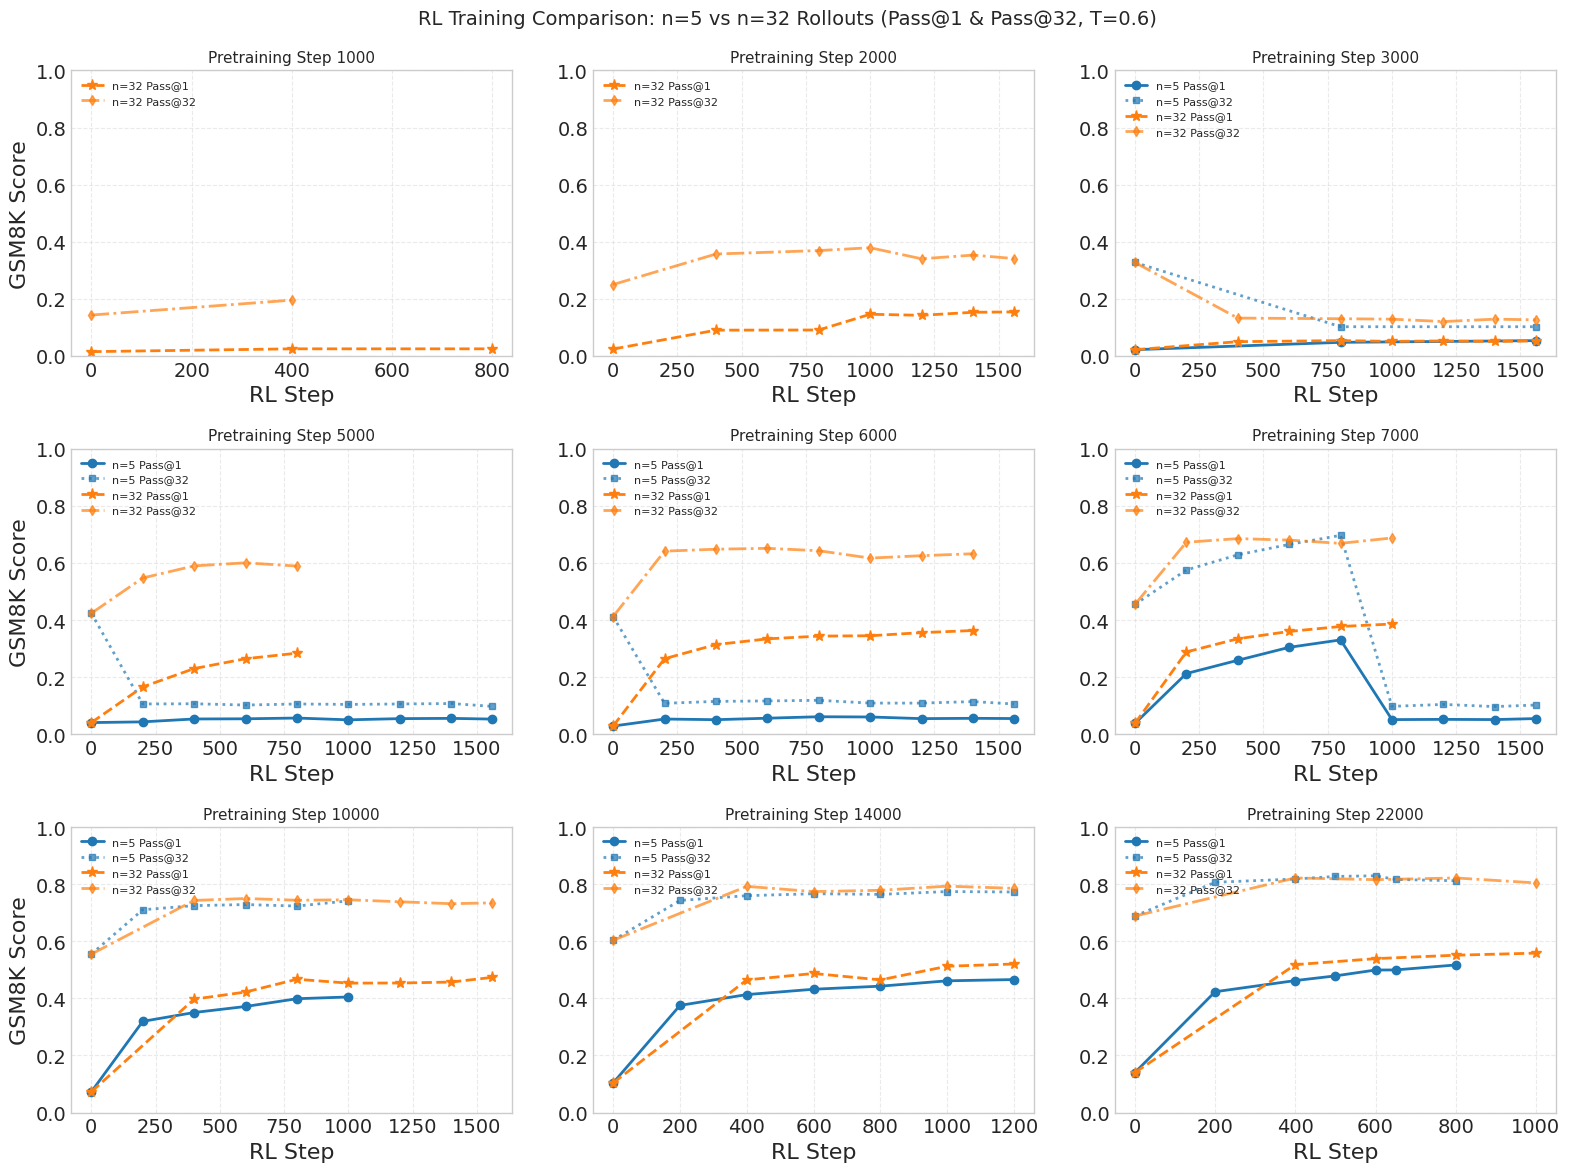

In [89]:
# Plot 7: RL n=5 vs n=32 Rollout Comparison - 3x3 grid for each pt_step
# Each subplot shows test GSM8K performance (pass@1 and pass@32) for both n=5 and n=32 rollouts
# For each (pt_step, num_rollouts, samples), pick the seed with best final performance
TARGET_TEMP = 0.6
TARGET_SHOT = 8

# Use the same pt_steps as Plot 6
pt_steps_plot7 = [1000, 2000, 3000, 5000, 6000, 7000, 10000, 14000, 22000]

# Helper function to select best seed for a given subset
def select_best_seed(rl_subset):
    """For a given RL subset, find the seed with best final performance and return only that seed's data."""
    if rl_subset.empty:
        return rl_subset
    # Step 1: Get the last rl_step for each seed
    last_step_idx = rl_subset.groupby("seed")["rl_step"].idxmax()
    last_step_scores = rl_subset.loc[last_step_idx]
    # Step 2: Pick the seed with max score at its last step
    best_seed = last_step_scores.loc[last_step_scores["score"].idxmax(), "seed"]
    # Step 3: Filter to only include the best seed
    return rl_subset[rl_subset["seed"] == best_seed].sort_values("rl_step")

# Create 3x3 grid
nrows = 3
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 12), sharey=False)
axes = axes.flatten()

# Colors for n=5 and n=32
color_n5 = "tab:blue"
color_n32 = "tab:orange"

for idx, pt_step in enumerate(pt_steps_plot7):
    if idx >= nrows * ncols:
        break
    ax = axes[idx]
    
    # Get pre-train scores for rl_step=0 (pass@1 and pass@32)
    pre_score_p1 = pre_df[
        (pre_df["step"] == pt_step) &
        (pre_df["samples"] == 1) &
        (pre_df["shot"] == TARGET_SHOT) &
        (pre_df["temp"] == TARGET_TEMP)
    ]
    start_score_p1 = pre_score_p1.iloc[0]["score"] if not pre_score_p1.empty else None
    
    pre_score_p32 = pre_df[
        (pre_df["step"] == pt_step) &
        (pre_df["samples"] == 32) &
        (pre_df["shot"] == TARGET_SHOT) &
        (pre_df["temp"] == TARGET_TEMP)
    ]
    start_score_p32 = pre_score_p32.iloc[0]["score"] if not pre_score_p32.empty else None
    
    # Plot RL n=5 rollout - Pass@1 (best seed)
    rl_n5_p1 = rl_df[
        (rl_df["pt_step"] == pt_step) &
        (rl_df["samples"] == 1) &
        (rl_df["temp"] == TARGET_TEMP) &
        (rl_df["num_rollouts"] == 5)
    ]
    rl_n5_p1 = select_best_seed(rl_n5_p1)
    
    if not rl_n5_p1.empty:
        if start_score_p1 is not None:
            xs = [0] + rl_n5_p1["rl_step"].tolist()
            ys = [start_score_p1] + rl_n5_p1["score"].tolist()
        else:
            xs = rl_n5_p1["rl_step"].tolist()
            ys = rl_n5_p1["score"].tolist()
        ax.plot(xs, ys, color=color_n5, marker="o", markersize=6, 
                label="n=5 Pass@1", linewidth=2, linestyle="-")
    
    # Plot RL n=5 rollout - Pass@32 (best seed)
    rl_n5_p32 = rl_df[
        (rl_df["pt_step"] == pt_step) &
        (rl_df["samples"] == 32) &
        (rl_df["temp"] == TARGET_TEMP) &
        (rl_df["num_rollouts"] == 5)
    ]
    rl_n5_p32 = select_best_seed(rl_n5_p32)
    
    if not rl_n5_p32.empty:
        if start_score_p32 is not None:
            xs = [0] + rl_n5_p32["rl_step"].tolist()
            ys = [start_score_p32] + rl_n5_p32["score"].tolist()
        else:
            xs = rl_n5_p32["rl_step"].tolist()
            ys = rl_n5_p32["score"].tolist()
        ax.plot(xs, ys, color=color_n5, marker="s", markersize=5, 
                label="n=5 Pass@32", linewidth=2, linestyle=":", alpha=0.7)
    
    # Plot RL n=32 rollout - Pass@1 (best seed)
    rl_n32_p1 = rl_df[
        (rl_df["pt_step"] == pt_step) &
        (rl_df["samples"] == 1) &
        (rl_df["temp"] == TARGET_TEMP) &
        (rl_df["num_rollouts"] == 32)
    ]
    rl_n32_p1 = select_best_seed(rl_n32_p1)
    
    if not rl_n32_p1.empty:
        if start_score_p1 is not None:
            xs = [0] + rl_n32_p1["rl_step"].tolist()
            ys = [start_score_p1] + rl_n32_p1["score"].tolist()
        else:
            xs = rl_n32_p1["rl_step"].tolist()
            ys = rl_n32_p1["score"].tolist()
        ax.plot(xs, ys, color=color_n32, marker="*", markersize=8, 
                label="n=32 Pass@1", linewidth=2, linestyle="--")
    
    # Plot RL n=32 rollout - Pass@32 (best seed)
    rl_n32_p32 = rl_df[
        (rl_df["pt_step"] == pt_step) &
        (rl_df["samples"] == 32) &
        (rl_df["temp"] == TARGET_TEMP) &
        (rl_df["num_rollouts"] == 32)
    ]
    rl_n32_p32 = select_best_seed(rl_n32_p32)
    
    if not rl_n32_p32.empty:
        if start_score_p32 is not None:
            xs = [0] + rl_n32_p32["rl_step"].tolist()
            ys = [start_score_p32] + rl_n32_p32["score"].tolist()
        else:
            xs = rl_n32_p32["rl_step"].tolist()
            ys = rl_n32_p32["score"].tolist()
        ax.plot(xs, ys, color=color_n32, marker="d", markersize=5, 
                label="n=32 Pass@32", linewidth=2, linestyle="-.", alpha=0.7)
    
    ax.set_title(f"Pretraining Step {pt_step}", fontsize=11)
    ax.set_xlabel("RL Step")
    if idx % ncols == 0:
        ax.set_ylabel("GSM8K Score")
    ax.set_ylim(0, 1.0)
    ax.grid(True, linestyle="--", alpha=0.4)
    ax.legend(loc="upper left", fontsize=8)

# Hide unused subplots
for idx in range(len(pt_steps_plot7), nrows * ncols):
    axes[idx].set_visible(False)

fig.suptitle("RL Training Comparison: n=5 vs n=32 Rollouts (Pass@1 & Pass@32, T=0.6)", fontsize=14)
plt.tight_layout()
plt.show()

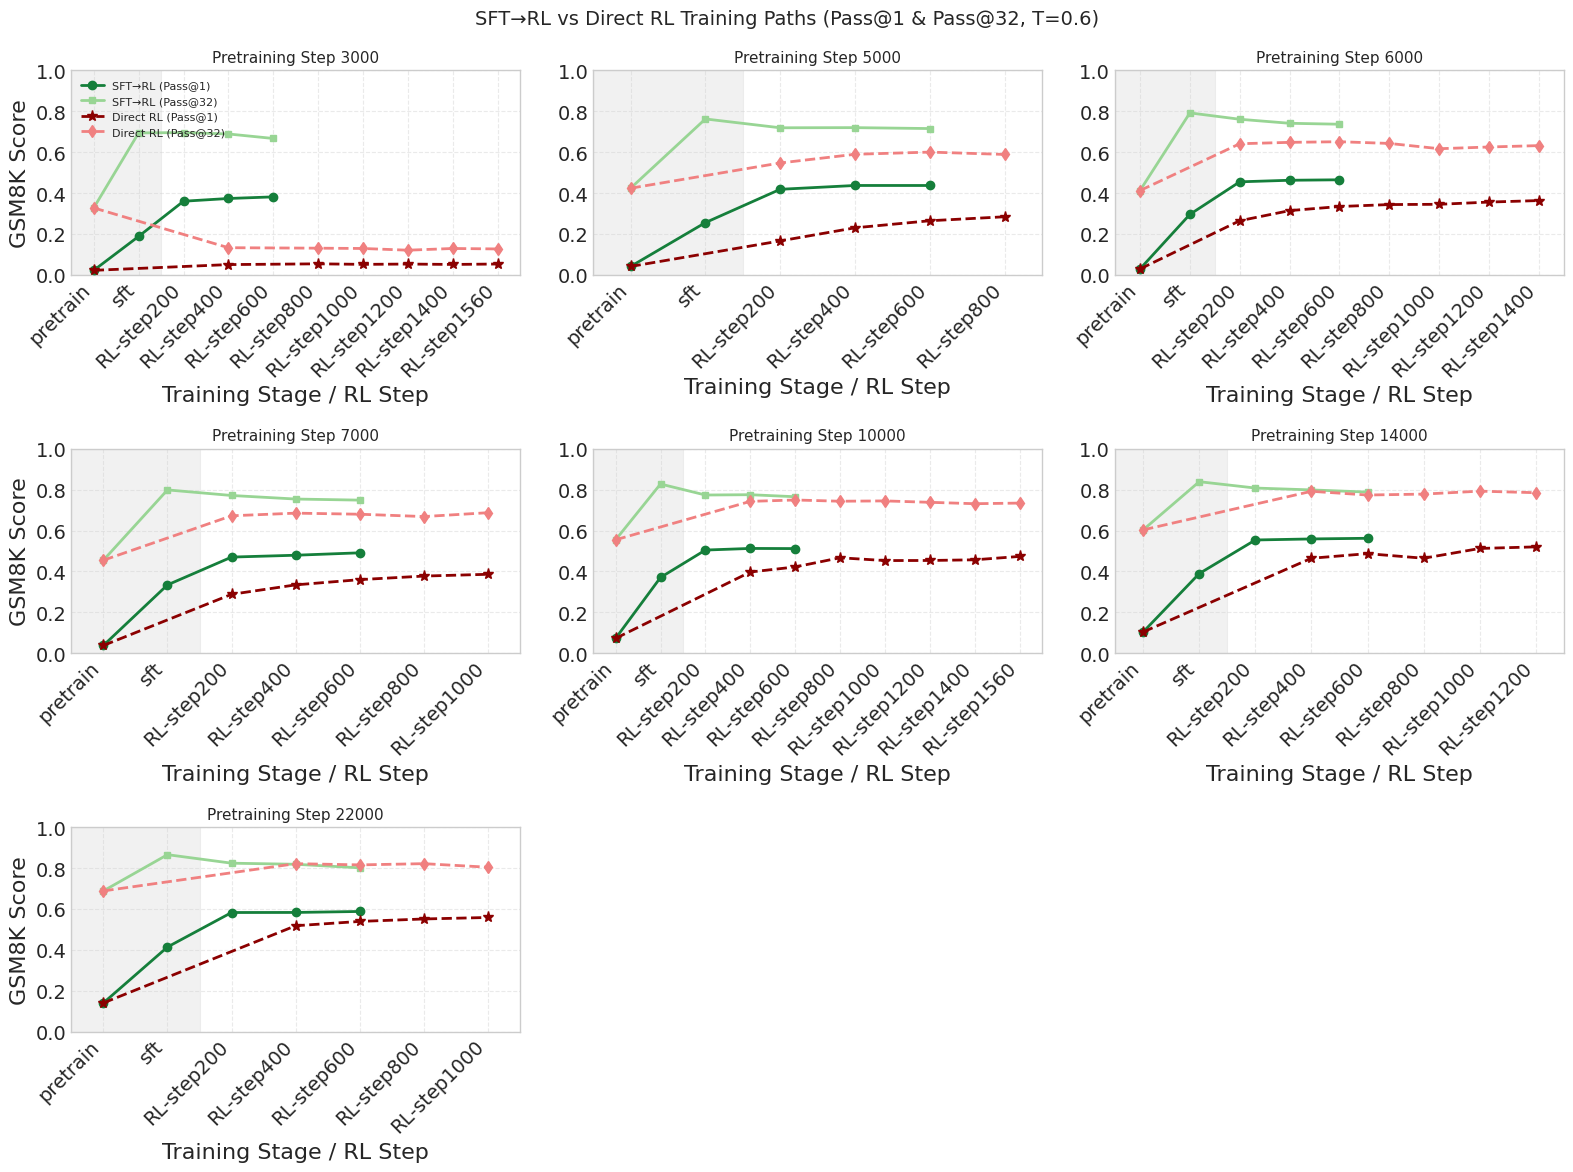

In [91]:
# Plot 8: SFTed-RL vs Direct RL Comparison - 3x3 grid for each pt_step
# Each subplot shows two training paths for Pass@1 and Pass@32:
#   1) SFTed-RL: pretrain (8-shot) → sft (5-epoch) → sfted_rl steps
#   2) Direct RL: pretrain (8-shot) → rl steps (from rl_df)
# X-axis: pretrain → sft → rl_step1 → rl_step2 → ...
# For Direct RL, pick the seed with best final performance
TARGET_TEMP = 0.6
TARGET_SHOT = 8
SFT_EPOCHS = 5
SFTED_RL_ROLLOUTS = 32
RL_ROLLOUTS = 32
SAMPLES_LIST = [1, 32]  # Pass@1 and Pass@32

# Helper function to select best seed for a given subset
def select_best_seed(rl_subset):
    """For a given RL subset, find the seed with best final performance and return only that seed's data."""
    if rl_subset.empty:
        return rl_subset
    # Step 1: Get the last rl_step for each seed
    last_step_idx = rl_subset.groupby("seed")["rl_step"].idxmax()
    last_step_scores = rl_subset.loc[last_step_idx]
    # Step 2: Pick the seed with max score at its last step
    best_seed = last_step_scores.loc[last_step_scores["score"].idxmax(), "seed"]
    # Step 3: Filter to only include the best seed
    return rl_subset[rl_subset["seed"] == best_seed].sort_values("rl_step")

# Get pt_steps from sfted_rl_df
pt_steps_plot8 = sorted(sfted_rl_df["pt_step"].unique()) if not sfted_rl_df.empty else []

# Create 3x3 grid
nrows = 3
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 12), sharey=False)
axes = axes.flatten()

# Colors - darker for Pass@1, lighter for Pass@32
sfted_rl_colors = {1: plt.get_cmap("Greens")(0.8), 32: plt.get_cmap("Greens")(0.4)}
direct_rl_colors = {1: "darkred", 32: "lightcoral"}  # True red colors

# Markers for different pass@k
markers_by_samples = {
    1: {"marker_sfted": "o", "marker_direct": "*", "markersize_sfted": 6, "markersize_direct": 8},
    32: {"marker_sfted": "s", "marker_direct": "d", "markersize_sfted": 5, "markersize_direct": 6},
}

# Define legend order: SFT→RL Pass@1, SFT→RL Pass@32, Direct RL Pass@1, Direct RL Pass@32
legend_order = ["SFT→RL (Pass@1)", "SFT→RL (Pass@32)", "Direct RL (Pass@1)", "Direct RL (Pass@32)"]

for idx, pt_step in enumerate(pt_steps_plot8):
    if idx >= nrows * ncols:
        break
    ax = axes[idx]
    
    # Collect all unique rl_steps from both datasets for x-axis (across all samples)
    all_rl_steps = set()
    for samples in SAMPLES_LIST:
        sfted_rl_subset = sfted_rl_df[
            (sfted_rl_df["pt_step"] == pt_step) &
            (sfted_rl_df["samples"] == samples) &
            (sfted_rl_df["temp"] == TARGET_TEMP) &
            (sfted_rl_df["num_rollouts"] == SFTED_RL_ROLLOUTS)
        ]
        direct_rl_subset = rl_df[
            (rl_df["pt_step"] == pt_step) &
            (rl_df["samples"] == samples) &
            (rl_df["temp"] == TARGET_TEMP) &
            (rl_df["num_rollouts"] == RL_ROLLOUTS)
        ]
        # Apply best seed selection to direct_rl_subset
        direct_rl_subset = select_best_seed(direct_rl_subset)
        if not sfted_rl_subset.empty:
            all_rl_steps.update(sfted_rl_subset["rl_step"].unique())
        if not direct_rl_subset.empty:
            all_rl_steps.update(direct_rl_subset["rl_step"].unique())
    all_rl_steps = sorted(all_rl_steps)
    
    # Create mapping from rl_step to x position (0=pretrain, 1=sft, 2+=rl_steps)
    rl_step_to_x = {step: 2 + i for i, step in enumerate(all_rl_steps)}
    
    # Add grey background for pretrain/sft section
    ax.axvspan(-0.5, 1.5, color='lightgrey', alpha=0.3, zorder=0)
    
    for samples in SAMPLES_LIST:
        style = markers_by_samples[samples]
        label_suffix = f" (Pass@{samples})"
        sfted_color = sfted_rl_colors[samples]
        direct_color = direct_rl_colors[samples]
        
        # Only add labels for the first subplot
        sfted_label = f"SFT→RL{label_suffix}" if idx == 0 else None
        direct_label = f"Direct RL{label_suffix}" if idx == 0 else None
        
        # 1. Get pretrain score (8-shot)
        pre_score_row = pre_df[
            (pre_df["step"] == pt_step) &
            (pre_df["samples"] == samples) &
            (pre_df["shot"] == TARGET_SHOT) &
            (pre_df["temp"] == TARGET_TEMP)
        ]
        pre_score = pre_score_row.iloc[0]["score"] if not pre_score_row.empty else None
        
        # 2. Get SFT score (5-epoch, last checkpoint)
        sft_subset = sft_df[
            (sft_df["pt_step"] == pt_step) &
            (sft_df["samples"] == samples) &
            (sft_df["temp"] == TARGET_TEMP) &
            (sft_df["sft_epochs"] == SFT_EPOCHS)
        ]
        if not sft_subset.empty:
            sft_last = sft_subset.loc[sft_subset["sft_step"].idxmax()]
            sft_score = sft_last["score"]
        else:
            sft_score = None
        
        # 3. Get SFTed-RL scores
        sfted_rl_subset = sfted_rl_df[
            (sfted_rl_df["pt_step"] == pt_step) &
            (sfted_rl_df["samples"] == samples) &
            (sfted_rl_df["temp"] == TARGET_TEMP) &
            (sfted_rl_df["num_rollouts"] == SFTED_RL_ROLLOUTS)
        ].sort_values("rl_step")
        
        # 4. Get Direct RL scores (best seed)
        direct_rl_subset = rl_df[
            (rl_df["pt_step"] == pt_step) &
            (rl_df["samples"] == samples) &
            (rl_df["temp"] == TARGET_TEMP) &
            (rl_df["num_rollouts"] == RL_ROLLOUTS)
        ]
        direct_rl_subset = select_best_seed(direct_rl_subset)
        
        # === SFTed-RL path ===
        # Build full line: pretrain → sft → sfted_rl steps
        xs_sfted = []
        ys_sfted = []
        
        if pre_score is not None:
            xs_sfted.append(0)
            ys_sfted.append(pre_score)
        
        if sft_score is not None:
            xs_sfted.append(1)
            ys_sfted.append(sft_score)
        
        if not sfted_rl_subset.empty:
            for _, row in sfted_rl_subset.iterrows():
                xs_sfted.append(rl_step_to_x[row["rl_step"]])
                ys_sfted.append(row["score"])
        
        if xs_sfted:
            ax.plot(xs_sfted, ys_sfted, marker=style["marker_sfted"], 
                    markersize=style["markersize_sfted"], color=sfted_color,
                    label=sfted_label, linewidth=2, linestyle="-", zorder=4)
        
        # === Direct RL path ===
        # Build full line: pretrain → rl steps
        xs_direct = []
        ys_direct = []
        
        if pre_score is not None:
            xs_direct.append(0)
            ys_direct.append(pre_score)
        
        if not direct_rl_subset.empty:  
            for _, row in direct_rl_subset.iterrows():
                if row["rl_step"] in rl_step_to_x:
                    xs_direct.append(rl_step_to_x[row["rl_step"]])
                    ys_direct.append(row["score"])
        
        if len(xs_direct) > 1:
            ax.plot(xs_direct, ys_direct, marker=style["marker_direct"], 
                    markersize=style["markersize_direct"], color=direct_color,
                    label=direct_label, linewidth=2, linestyle="--", zorder=4)
    
    # Set x-axis ticks and labels
    all_x_positions = [0, 1] + [2 + i for i in range(len(all_rl_steps))]
    x_tick_labels = ["pretrain", "sft"] + [f"RL-step{s}" for s in all_rl_steps]
    
    ax.set_xticks(all_x_positions)
    ax.set_xticklabels(x_tick_labels, rotation=45, ha="right")
    ax.set_xlim(-0.5, max(all_x_positions) + 0.5 if all_x_positions else 2.5)
    
    ax.set_title(f"Pretraining Step {pt_step}", fontsize=11)
    ax.set_xlabel("Training Stage / RL Step")
    if idx % ncols == 0:
        ax.set_ylabel("GSM8K Score")
    ax.set_ylim(0, 1.0)
    ax.grid(True, linestyle="--", alpha=0.4)
    
    # Only show legend in the first subplot, with custom order
    if idx == 0:
        handles, labels = ax.get_legend_handles_labels()
        # Sort handles and labels according to legend_order
        label_to_handle = dict(zip(labels, handles))
        sorted_handles = [label_to_handle[l] for l in legend_order if l in label_to_handle]
        sorted_labels = [l for l in legend_order if l in label_to_handle]
        ax.legend(sorted_handles, sorted_labels, loc="upper left", fontsize=8)

# Hide unused subplots
for idx in range(len(pt_steps_plot8), nrows * ncols):
    axes[idx].set_visible(False)

fig.suptitle(f"SFT→RL vs Direct RL Training Paths (Pass@1 & Pass@32, T={TARGET_TEMP})", fontsize=14)
plt.tight_layout()
plt.show()

In [93]:
# fineweb-math for pre-training
# tiny-gsm numbers
# how back we can push the RL
# maybe we can push it way back and make up for pre-training but having to spend lot more FLOPs on RL
# poking around datasets

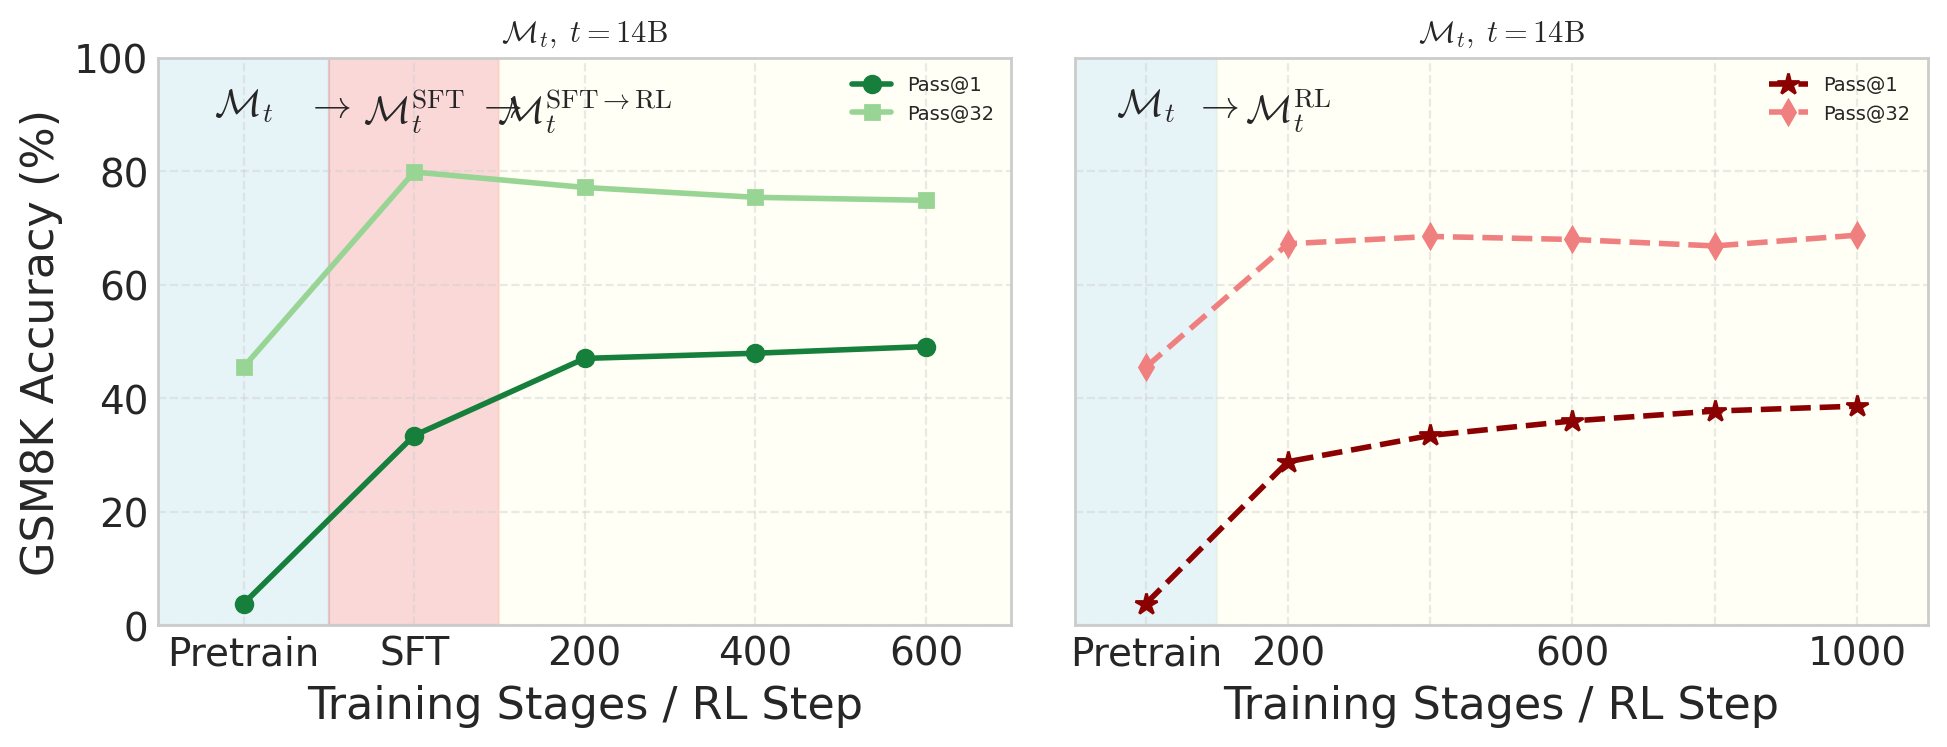

In [43]:
# Plot 9: Succinct 2-panel comparison (subset of Plot 8)
# Panel 1: Pretrain→SFT→RL (green) for pt_step=7000
# Panel 2: Pretrain→RL (red) for pt_step=7000

from matplotlib.legend import Legend

TARGET_TEMP = 0.6
TARGET_SHOT = 8
SFT_EPOCHS = 5
SFTED_RL_ROLLOUTS = 32
RL_ROLLOUTS = 32
SAMPLES_LIST = [1, 32]  # Pass@1 and Pass@32

# Panel configurations: (pt_step, line_type, title)
# Each step = 2M tokens, so 7000 steps = 14B tokens
panel_configs = [
    (7000, 'sfted', r'$\mathcal{M}_t,\; t=14\mathrm{B}$'),
    (7000, 'direct', r'$\mathcal{M}_t,\; t=14\mathrm{B}$'),
]

# Colors - darker for Pass@1, lighter for Pass@32
sfted_rl_colors = {1: plt.get_cmap("Greens")(0.8), 32: plt.get_cmap("Greens")(0.4)}
direct_rl_colors = {1: "darkred", 32: "lightcoral"}

# Background colors for stages
PRETRAIN_COLOR = 'lightblue'
SFT_COLOR = 'lightcoral'
RL_COLOR = 'lightyellow'

# Markers for different pass@k
markers_by_samples = {
    1: {"marker_sfted": "o", "marker_direct": "*", "markersize_sfted": 6, "markersize_direct": 8},
    32: {"marker_sfted": "s", "marker_direct": "d", "markersize_sfted": 5, "markersize_direct": 6},
}

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True, dpi=200)

for panel_idx, (pt_step, line_type, title) in enumerate(panel_configs):
    ax = axes[panel_idx]
    
    # Collect all unique rl_steps for this panel
    all_rl_steps = set()
    for samples in SAMPLES_LIST:
        if line_type == 'sfted':
            subset = sfted_rl_df[
                (sfted_rl_df["pt_step"] == pt_step) &
                (sfted_rl_df["samples"] == samples) &
                (sfted_rl_df["temp"] == TARGET_TEMP) &
                (sfted_rl_df["num_rollouts"] == SFTED_RL_ROLLOUTS)
            ]
        else:  # direct
            subset = rl_df[
                (rl_df["pt_step"] == pt_step) &
                (rl_df["samples"] == samples) &
                (rl_df["temp"] == TARGET_TEMP) &
                (rl_df["num_rollouts"] == RL_ROLLOUTS)
            ]
            subset = select_best_seed(subset)
        if not subset.empty:
            all_rl_steps.update(subset["rl_step"].unique())
    all_rl_steps = sorted(all_rl_steps)
    
    # Create mapping: for sfted (pretrain, sft, rl_steps), for direct (pretrain, rl_steps)
    if line_type == 'sfted':
        rl_step_to_x = {step: 2 + i for i, step in enumerate(all_rl_steps)}
        ax.axvspan(-0.5, 0.5, color=PRETRAIN_COLOR, alpha=0.3, zorder=0)
        ax.axvspan(0.5, 1.5, color=SFT_COLOR, alpha=0.3, zorder=0)
        if all_rl_steps:
            ax.axvspan(1.5, max(rl_step_to_x.values()) + 0.5, color=RL_COLOR, alpha=0.3, zorder=0)
        # Top labels with math notation and arrows
        ax.text(0, 0.95, r'$\mathcal{M}_t$', ha='center', va='top', fontsize=14, transform=ax.get_xaxis_transform())
        ax.text(0.5, 0.95, r'$\rightarrow$', ha='center', va='top', fontsize=14, transform=ax.get_xaxis_transform())
        ax.text(1, 0.95, r'$\mathcal{M}_t^{\mathrm{SFT}}$', ha='center', va='top', fontsize=14, transform=ax.get_xaxis_transform())
        if all_rl_steps:
            rl_center = (1.5 + max(rl_step_to_x.values()) + 0.5) / 3
            ax.text(1.5, 0.95, r'$\rightarrow$', ha='center', va='top', fontsize=14, transform=ax.get_xaxis_transform())
            ax.text(rl_center, 0.95, r'$\mathcal{M}_t^{\mathrm{SFT \to RL}}$', ha='center', va='top', fontsize=14, transform=ax.get_xaxis_transform())
    else:
        rl_step_to_x = {step: 1 + i for i, step in enumerate(all_rl_steps)}
        ax.axvspan(-0.5, 0.5, color=PRETRAIN_COLOR, alpha=0.3, zorder=0)
        if all_rl_steps:
            ax.axvspan(0.5, max(rl_step_to_x.values()) + 0.5, color=RL_COLOR, alpha=0.3, zorder=0)
        # Top labels with math notation and arrows
        ax.text(0, 0.95, r'$\mathcal{M}_t$', ha='center', va='top', fontsize=14, transform=ax.get_xaxis_transform())
        if all_rl_steps:
            rl_center = (0.5 + max(rl_step_to_x.values()) + 0.5) / 6
            ax.text(0.5, 0.95, r'$\rightarrow$', ha='center', va='top', fontsize=14, transform=ax.get_xaxis_transform())
            ax.text(rl_center, 0.95, r'$\mathcal{M}_t^{\mathrm{RL}}$', ha='center', va='top', fontsize=14, transform=ax.get_xaxis_transform())
    
    for samples in SAMPLES_LIST:
        style = markers_by_samples[samples]
        
        # Get pretrain score
        pre_score_row = pre_df[
            (pre_df["step"] == pt_step) &
            (pre_df["samples"] == samples) &
            (pre_df["shot"] == TARGET_SHOT) &
            (pre_df["temp"] == TARGET_TEMP)
        ]
        pre_score = pre_score_row.iloc[0]["score"] if not pre_score_row.empty else None
        
        if line_type == 'sfted':
            color = sfted_rl_colors[samples]
            marker = style["marker_sfted"]
            markersize = style["markersize_sfted"]
            linestyle = "-"
            label = f"Pass@{samples}"
            
            sft_subset = sft_df[
                (sft_df["pt_step"] == pt_step) &
                (sft_df["samples"] == samples) &
                (sft_df["temp"] == TARGET_TEMP) &
                (sft_df["sft_epochs"] == SFT_EPOCHS)
            ]
            sft_score = sft_subset.loc[sft_subset["sft_step"].idxmax()]["score"] if not sft_subset.empty else None
            
            rl_subset = sfted_rl_df[
                (sfted_rl_df["pt_step"] == pt_step) &
                (sfted_rl_df["samples"] == samples) &
                (sfted_rl_df["temp"] == TARGET_TEMP) &
                (sfted_rl_df["num_rollouts"] == SFTED_RL_ROLLOUTS)
            ].sort_values("rl_step")
            
            xs, ys = [], []
            if pre_score is not None:
                xs.append(0)
                ys.append(pre_score * 100)
            if sft_score is not None:
                xs.append(1)
                ys.append(sft_score * 100)
            for _, row in rl_subset.iterrows():
                xs.append(rl_step_to_x[row["rl_step"]])
                ys.append(row["score"] * 100)
        
        else:  # direct
            color = direct_rl_colors[samples]
            marker = style["marker_direct"]
            markersize = style["markersize_direct"]
            linestyle = "--"
            label = f"Pass@{samples}"
            
            rl_subset = rl_df[
                (rl_df["pt_step"] == pt_step) &
                (rl_df["samples"] == samples) &
                (rl_df["temp"] == TARGET_TEMP) &
                (rl_df["num_rollouts"] == RL_ROLLOUTS)
            ]
            best_subset = select_best_seed(rl_subset)
            
            xs, ys = [], []
            if pre_score is not None:
                xs.append(0)
                ys.append(pre_score * 100)
            for _, row in best_subset.iterrows():
                if row["rl_step"] in rl_step_to_x:
                    xs.append(rl_step_to_x[row["rl_step"]])
                    ys.append(row["score"] * 100)
        
        if xs:
            ax.plot(xs, ys, marker=marker, markersize=markersize, color=color,
                    label=label, linewidth=2, linestyle=linestyle, zorder=4)
    
    # Set x-axis ticks and labels
    if line_type == 'sfted':
        all_x_positions = [0, 1] + [2 + i for i in range(len(all_rl_steps))]
        x_tick_labels = ["Pretrain", "SFT"] + [str(s) for s in all_rl_steps]
    else:
        all_x_positions = [0] + [1 + i for i in range(len(all_rl_steps))]
        x_tick_labels = ["Pretrain"] + [str(s) for s in all_rl_steps]
    
    # Thin out RL x-ticks (show every 2nd) for direct panels
    if line_type == 'direct':
        rl_positions = all_x_positions[1:]  # skip pretrain
        rl_labels = x_tick_labels[1:]
        thinned_positions = [all_x_positions[0]]
        thinned_labels = [x_tick_labels[0]]
        for i, (pos, lbl) in enumerate(zip(rl_positions, rl_labels)):
            if i % 2 == 0:
                thinned_positions.append(pos)
                thinned_labels.append(lbl)
            else:
                thinned_positions.append(pos)
                thinned_labels.append("")
        all_x_positions = thinned_positions
        x_tick_labels = thinned_labels
    
    ax.set_xticks(all_x_positions)
    ax.set_xticklabels(x_tick_labels, rotation=0, ha="center")
    ax.set_xlim(-0.5, max(all_x_positions) + 0.5 if all_x_positions else 1.5)
    
    ax.set_title(title, fontsize=11)
    ax.set_xlabel("Training Stages / RL Step")
    if panel_idx == 0:
        ax.set_ylabel("GSM8K Accuracy (%)")
    ax.set_ylim(0, 100)
    ax.grid(True, linestyle="--", alpha=0.4)
    ax.legend(loc="upper right", fontsize=7)

plt.tight_layout()
plt.savefig("/n/home05/sqin/rl_pretrain/verl/notebooks/gsm8k_rl_train_dynamics_comparison.pdf", bbox_inches="tight")
plt.show()

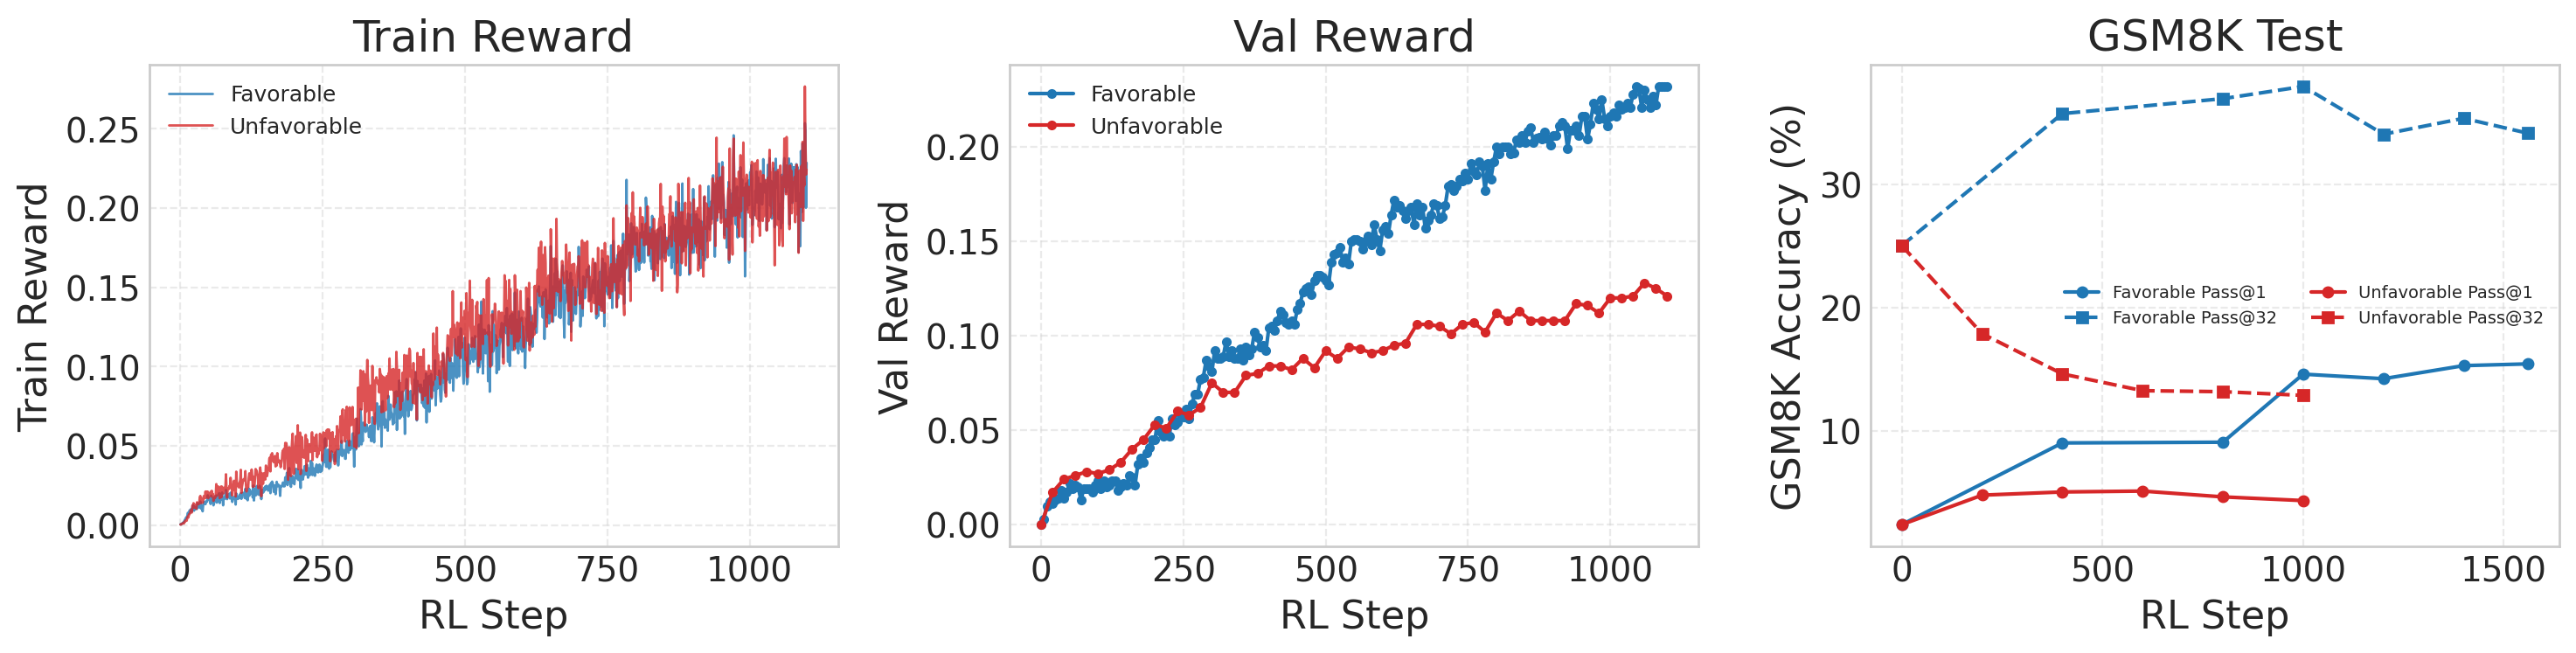

In [44]:
# Plot 10: Seed Comparison — Train Reward, Val Reward, GSM8K Test
# Favorable seed: olmo2_1b_step2000_omigsm8k_n32 (seed 1)
# Unfavorable seed: olmo2_1b_step2000_omigsm8k_n32_v2 (seed 2)

import pandas as pd

# --- Load reward CSVs ---
train_reward_df = pd.read_csv('/n/home05/sqin/rl_pretrain/verl/notebooks/result_files/gsm_step2k_train_reward_seeds.csv')
val_reward_df = pd.read_csv('/n/home05/sqin/rl_pretrain/verl/notebooks/result_files/gsm_step2k_val_reward_seeds.csv')

best_train_col = 'Name: olmo2_1b_step2000_omigsm8k_n32 - critic/score/mean'
worse_train_col = 'Name: olmo2_1b_step2000_omigsm8k_n32_v2 - critic/score/mean'
best_val_col = 'Name: olmo2_1b_step2000_omigsm8k_n32 - val-core/nvidia/OpenMathInstruct-2/reward/mean@1'
worse_val_col = 'Name: olmo2_1b_step2000_omigsm8k_n32_v2 - val-core/nvidia/OpenMathInstruct-2/reward/mean@1'

# --- Colors & labels ---
FAV_COLOR = '#1f77b4'    # blue
UNFAV_COLOR = '#d62728'  # red
FAV_LABEL = 'Favorable'
UNFAV_LABEL = 'Unfavorable'
STEP_CUTOFF = 1100

fig, axes = plt.subplots(1, 3, figsize=(15, 4), dpi=200)

# ---- Panel 1: Train Reward ----
ax = axes[0]
train_best = train_reward_df[['Step', best_train_col]].dropna()
train_worse = train_reward_df[['Step', worse_train_col]].dropna()
train_best = train_best[train_best['Step'] <= STEP_CUTOFF]
train_worse = train_worse[train_worse['Step'] <= STEP_CUTOFF]
ax.plot(train_best['Step'], train_best[best_train_col],
        label=FAV_LABEL, color=FAV_COLOR, linewidth=1.0, alpha=0.8)
ax.plot(train_worse['Step'], train_worse[worse_train_col],
        label=UNFAV_LABEL, color=UNFAV_COLOR, linewidth=1.0, alpha=0.8)
ax.set_xlabel('RL Step')
ax.set_ylabel('Train Reward')
ax.set_title('Train Reward')
ax.legend(fontsize=9)
ax.grid(True, linestyle='--', alpha=0.4)

# ---- Panel 2: Val Reward ----
ax = axes[1]
val_best = val_reward_df[['Step', best_val_col]].dropna()
val_worse = val_reward_df[['Step', worse_val_col]].dropna()
val_best = val_best[val_best['Step'] <= STEP_CUTOFF]
val_worse = val_worse[val_worse['Step'] <= STEP_CUTOFF]
ax.plot(val_best['Step'], val_best[best_val_col],
        label=FAV_LABEL, color=FAV_COLOR, linewidth=1.5, marker='o', markersize=3)
ax.plot(val_worse['Step'], val_worse[worse_val_col],
        label=UNFAV_LABEL, color=UNFAV_COLOR, linewidth=1.5, marker='o', markersize=3)
ax.set_xlabel('RL Step')
ax.set_ylabel('Val Reward')
ax.set_title('Val Reward')
ax.legend(fontsize=9)
ax.grid(True, linestyle='--', alpha=0.4)

# ---- Panel 3: GSM8K Test Performance ----
ax = axes[2]
# Get pretrain score for pt_step=2000 (8-shot, temp=0.6)
TARGET_TEMP = 0.6
TARGET_SHOT = 8
for seed, label, color in [(1, FAV_LABEL, FAV_COLOR), (2, UNFAV_LABEL, UNFAV_COLOR)]:
    for samples, ls, mk in [(1, '-', 'o'), (32, '--', 's')]:
        # Get pretrain score as first point
        pre_score_row = pre_df[
            (pre_df["step"] == 2000) &
            (pre_df["samples"] == samples) &
            (pre_df["shot"] == TARGET_SHOT) &
            (pre_df["temp"] == TARGET_TEMP)
        ]
        pre_score = pre_score_row.iloc[0]["score"] * 100 if not pre_score_row.empty else None

        subset = rl_df[
            (rl_df['pt_step'] == 2000) &
            (rl_df['seed'] == seed) &
            (rl_df['num_rollouts'] == 32) &
            (rl_df['samples'] == samples) &
            (rl_df['temp'] == 0.6)
        ].sort_values('rl_step')

        xs, ys = [], []
        if pre_score is not None:
            xs.append(0)
            ys.append(pre_score)
        if not subset.empty:
            xs.extend(subset['rl_step'].tolist())
            ys.extend((subset['score'] * 100).tolist())
        if xs:
            ax.plot(xs, ys,
                    label=f'{label} Pass@{samples}',
                    color=color, linestyle=ls, marker=mk, markersize=4, linewidth=1.5)
ax.set_xlabel('RL Step')
ax.set_ylabel('GSM8K Accuracy (%)')
ax.set_title('GSM8K Test')
ax.legend(fontsize=7, ncol=2)
ax.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.savefig("/n/home05/sqin/rl_pretrain/verl/notebooks/gsm8k_seed_rewards.pdf", bbox_inches="tight")
plt.show()

In [ ]:
# Concise table with columns for pass@1/8/32/128 (pre, best SFT, best RL)
TARGET_KS = [1, 8, 32, 128]

rows = []
all_steps = sorted(pre_df["step"].unique().tolist())
for step in all_steps:
    row = {"pt_step": step}
    for k in TARGET_KS:
        temp = TEMP_BY_SAMPLES(k)
        shot = SHOT_BY_SAMPLES(k)

        pre_slice = pre_df[(pre_df["step"] == step) & (pre_df["samples"] == k) & (pre_df["temp"] == temp) & (pre_df["shot"] == shot)]
        row[f"pre_p{k}"] = pre_slice.iloc[-1]["score"] if not pre_slice.empty else None

        sft_slice = sft_df[(sft_df["pt_step"] == step) & (sft_df["samples"] == k) & (sft_df["temp"] == temp)]
        if not sft_slice.empty:
            best_sft = sft_slice.loc[sft_slice["total_step"].idxmax()]
            row[f"sft_p{k}"] = best_sft["score"]
            # row[f"sft_step{k}"] = best_sft["total_step"]
        else:
            row[f"sft_p{k}"] = None
            # row[f"sft_step{k}"] = None

        rl_slice = rl_df[(rl_df["pt_step"] == step) & (rl_df["samples"] == k) & (rl_df["temp"] == temp)]
        if not rl_slice.empty:
            best_rl = rl_slice.loc[rl_slice["total_step"].idxmax()]
            row[f"rl_p{k}"] = best_rl["score"]
            # row[f"rl_step{k}"] = best_rl["total_step"]
        else:
            row[f"rl_p{k}"] = None
            # row[f"rl_step{k}"] = None

    rows.append(row)

concise_df = pd.DataFrame(rows).sort_values("pt_step").reset_index(drop=True)
concise_df

 

,pt_step,pre_p1,sft_p1,rl_p1,pre_p8,sft_p8,rl_p8,pre_p32,sft_p32,rl_p32,pre_p128,sft_p128,rl_p128
0,1000,0.0050,0.1146,0.0394,0.0156,0.3469,0.0516,0.0376,0.5268,0.0560,None,None,NaN
1,2000,0.0064,0.0156,NaN,0.0305,0.0918,NaN,0.0776,0.2228,NaN,None,None,NaN
2,3000,0.0022,0.1391,0.0480,0.0184,0.3924,0.0610,0.0600,0.5644,0.0660,None,None,NaN
3,5000,0.0114,0.1445,0.0514,0.0586,0.4122,0.0763,0.1390,0.5832,0.0956,None,None,0.0988
4,6000,0.0150,0.0254,NaN,0.0774,0.1207,NaN,0.1884,0.2614,NaN,None,None,NaN
5,7000,0.0110,0.1568,NaN,0.0720,0.4272,NaN,0.1682,0.5976,NaN,None,None,NaN
6,10000,0.0090,0.2091,0.0660,0.0628,0.4873,0.1098,0.1644,0.6410,0.1420,None,None,NaN
7,14000,0.0122,0.1678,0.0640,0.0644,0.4580,0.0751,0.1616,0.6256,0.0794,None,None,NaN
8,22000,0.0110,0.2137,0.0796,0.0601,0.5043,0.1044,0.1640,0.6598,0.1222,None,None,NaN
